In [46]:
import numpy as n
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clip
from photutils.aperture import CircularAperture
from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry

import glob
from scipy import optimize
from spectral_cube import SpectralCube

from scipy.interpolate import interp1d

In [47]:
def gauss2d(x, y, x0, y0, offset, sigma_x, sigma_y, A):

    x_exp = ( ( x - x0 )**2) / (2 * sigma_x ** 2)
    y_exp = ( ( y - y0 )**2) / (2 * sigma_y ** 2)
    f = A * n.exp( - x_exp - y_exp) + offset

    return f

def image_solve(constants, im):

    x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val = constants

    y_len, x_len = im.shape
    y_arr = n.arange(0, y_len)
    x_arr = n.arange(0, x_len)
    xx, yy = n.meshgrid(x_arr, y_arr)

    fit = gauss2d(xx, yy, x0_val, y0_val, offset_val, sigma_x_val, sigma_y_val, A_val)

    min_diff = n.nansum(abs(im - fit)**2)

    return min_diff

def bin_array(array, w, no_elems, dpix, sig_clip = None, extra_array = None):

    binned_array = n.zeros(no_elems)
    binned_array_err = n.zeros(no_elems)
    if extra_array is not None:
        binned_extra_array = n.zeros(no_elems)     

    for i in range(no_elems):

        array_subset = array[i*dpix : i*dpix + dpix]
        w_subset = w[i*dpix : i*dpix + dpix]

        if extra_array is not None:
            extra_subset = extra_array[i*dpix : i*dpix + dpix]
        
        good = n.where( (n.isnan(w_subset) == False) & (n.isnan(array_subset) == False))

        if len(good[0]) == 0:

            binned_array[i] = n.nan
            binned_array_err[i] = n.nan

            if extra_array is not None:
                binned_extra_array[i] = n.nan
                
        else:

            array_subset =  array_subset[good]
            w_subset =  w_subset[good]
            if extra_array is not None:
                extra_subset = extra_subset[good]
            
            if sig_clip is not None:
                array_subset = sigma_clip(array_subset, sigma = sig_clip)

                if extra_array is not None:
                    extra_subset =  extra_subset[~array_subset.mask]

                w_subset = w_subset[~array_subset.mask]
                array_subset = array_subset[~array_subset.mask]
          
            binned_array[i] = n.nansum(array_subset * w_subset) / n.nansum(w_subset)
            binned_array_err[i] = n.sqrt(1/ n.nansum(w_subset))
            if extra_array is not None:
                 binned_extra_array[i] = n.nansum(extra_subset * w_subset) / n.nansum(w_subset)


    if extra_array is not None:
        return  binned_array, binned_array_err, binned_extra_array

    else:
        return  binned_array, binned_array_err


In [48]:
m2micron = 1e6       #[microns/meters]
c = 2.99792458e8     #[m/s]

def convert_Jy_to_F_lam(wave_arr, flux_arr):
    
    #flux_arr input array in jansky
    #wave_arr input array in microns
    
    wave_arr_meters = wave_arr/m2micron        #meters
    flux_arr *= 1e-26           #[W/m^2/Hz]
    flux_arr *= c/(wave_arr_meters**2) #[W/m^2/m]
    flux_arr /= m2micron        #[W/m^2/microns] 
    
    return flux_arr

In [49]:
##Code to Bin and Interpolate Spectra

def bin_and_interpolate_model(spec_lam, model_lam, model_flux, lam_buffer = .1):

    #re ordering the arrays according to wavelength
    order = n.argsort(model_lam)
    
    model_lam = model_lam[order]
    model_flux = model_flux[order]


    lam_min = n.nanmin(spec_lam) - lam_buffer  #edge minus buffer
    lam_max = n.nanmax(spec_lam) + lam_buffer  #edge plus buffer

    relevant = n.where((model_lam > lam_min) & (model_lam < lam_max))
    model_flux_relevant = model_flux[relevant]
    model_lam_relevant = model_lam[relevant]

    dlam_data = n.nanmedian(n.diff(spec_lam))
    dlam_model = n.nanmedian(n.diff(model_lam_relevant))
    
    print(dlam_data)
    print(dlam_model)
    
    dpix = int(dlam_data/dlam_model)

    if dpix > 1:
        elems = int(len(model_flux_relevant)/dpix)
        w = n.ones(model_flux_relevant.shape)

        model_flux_relevant_bin,  dummy_var, model_lam_relevant_bin  = bin_array(model_flux_relevant, w, elems, dpix, extra_array = model_lam_relevant)
        model_interp_f = interp1d(model_lam_relevant_bin, model_flux_relevant_bin)

        model_flux_relevant_interp = model_interp_f(spec_lam)
    
        return model_flux_relevant_interp

    else:

        model_interp_f = interp1d(model_lam_relevant, model_flux_relevant)

        model_flux_relevant_interp = model_interp_f(spec_lam)

        return model_flux_relevant_interp
        

In [50]:
cube_data1 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03104_00001_nrs1_s3d.fits')
cube1=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03104_00001_nrs1_s3d.fits',hdu=1)
cube_data_err1 = fits.open('all_dithers_detector1/stage2/jw01128009001_03104_00001_nrs1_s3d.fits')['ERR'].data
wavelength1=cube1.spectral_axis
wavelength1=n.array(wavelength1)

cube_data2 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03104_00002_nrs1_s3d.fits')
cube2=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03104_00002_nrs1_s3d.fits',hdu=1)
cube_data_err2 = fits.open('all_dithers_detector1/stage2/jw01128009001_03104_00002_nrs1_s3d.fits')['ERR'].data
wavelength2=cube2.spectral_axis
wavelength2=n.array(wavelength2)

cube_data3 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03104_00003_nrs1_s3d.fits')
cube3=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03104_00003_nrs1_s3d.fits',hdu=1)
cube_data_err3 = fits.open('all_dithers_detector1/stage2/jw01128009001_03104_00003_nrs1_s3d.fits')['ERR'].data
wavelength3=cube3.spectral_axis
wavelength3=n.array(wavelength3)


cube_data4 = fits.getdata('all_dithers_detector1/stage2/jw01128009001_03104_00004_nrs1_s3d.fits')
cube4=SpectralCube.read('all_dithers_detector1/stage2/jw01128009001_03104_00004_nrs1_s3d.fits',hdu=1)
cube_data_err4 = fits.open('all_dithers_detector1/stage2/jw01128009001_03104_00004_nrs1_s3d.fits')['ERR'].data
wavelength4=cube4.spectral_axis
wavelength4=n.array(wavelength4)

In [51]:
cube_collapse1 = n.nanmedian(cube_data1, axis = 0)
cube_collapse2 = n.nanmedian(cube_data2, axis = 0)
cube_collapse3 = n.nanmedian(cube_data3, axis = 0)
cube_collapse4 = n.nanmedian(cube_data4, axis = 0)

cube_collapse_err1 = n.nanmedian(cube_data_err1, axis = 0)
cube_collapse_err2 = n.nanmedian(cube_data_err2, axis = 0)
cube_collapse_err3 = n.nanmedian(cube_data_err3, axis = 0)
cube_collapse_err4 = n.nanmedian(cube_data_err4, axis = 0)

# DITHER 1

<IPython.core.display.Javascript object>


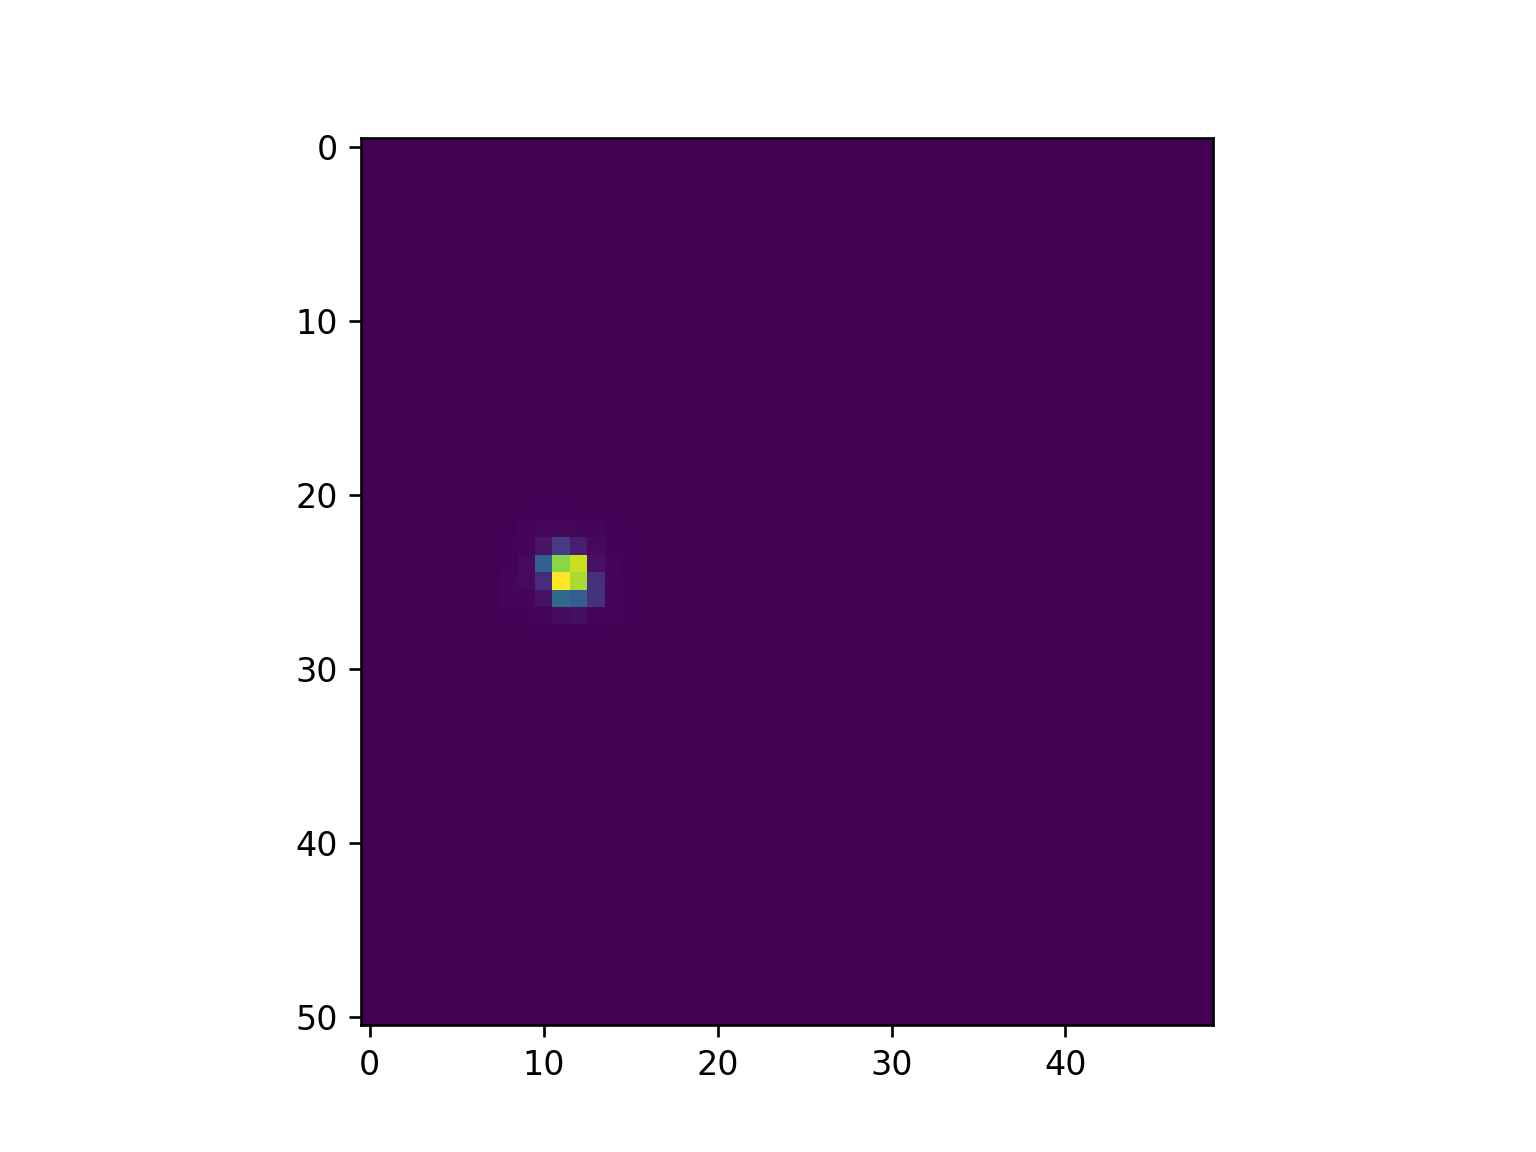

In [52]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse1/n.nanmax(cube_collapse1)))#, vmin = 0, vmax = 5e-10)
plt.show()

centroids (x, y)
11.437572738704247 24.61876773384344
sigmax, sigma y
1.0000000000000078 1.0000000000004627


<IPython.core.display.Javascript object>


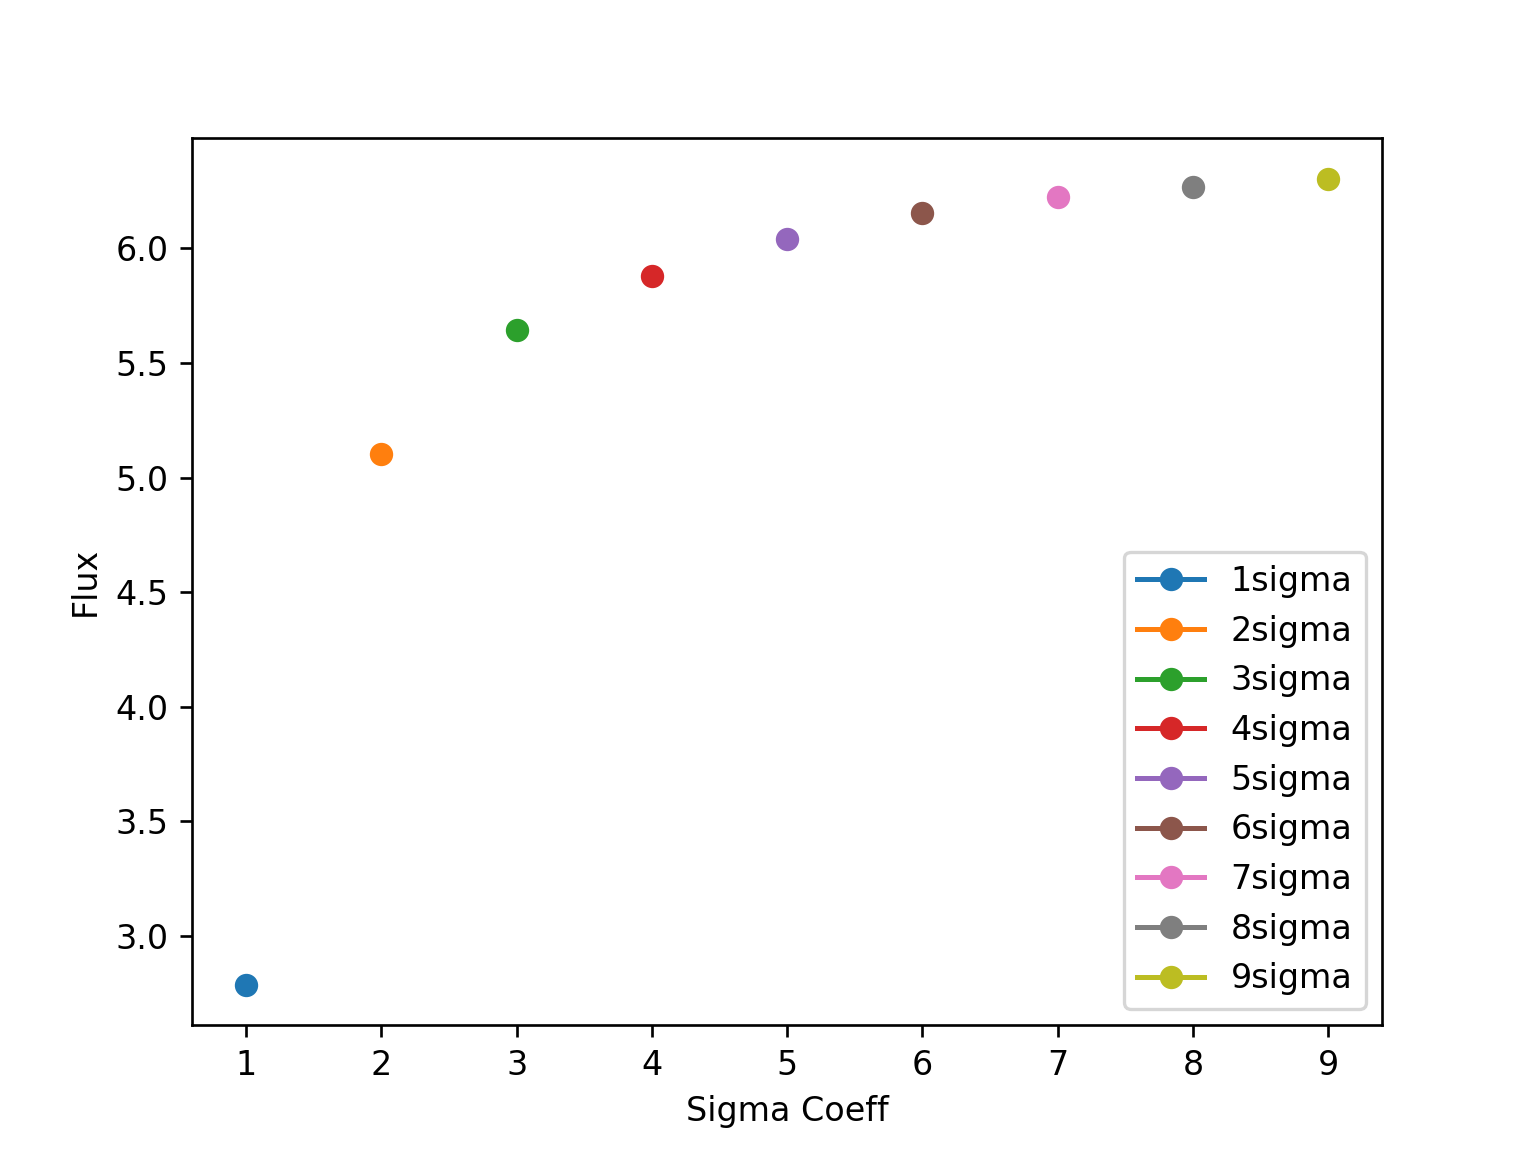

Text(0.5, 0, 'Sigma Coeff')

In [53]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse1/n.nanmax(cube_collapse1)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([11, 24, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [54]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data1.shape
flux1 = n.zeros(n_images)
error1 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data1[i]
    image_error = cube_data_err1[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    #EllipticalAperture(image, aperture, )
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux1[i] = flux_val 
    error1[i] = flux_val_err

<IPython.core.display.Javascript object>


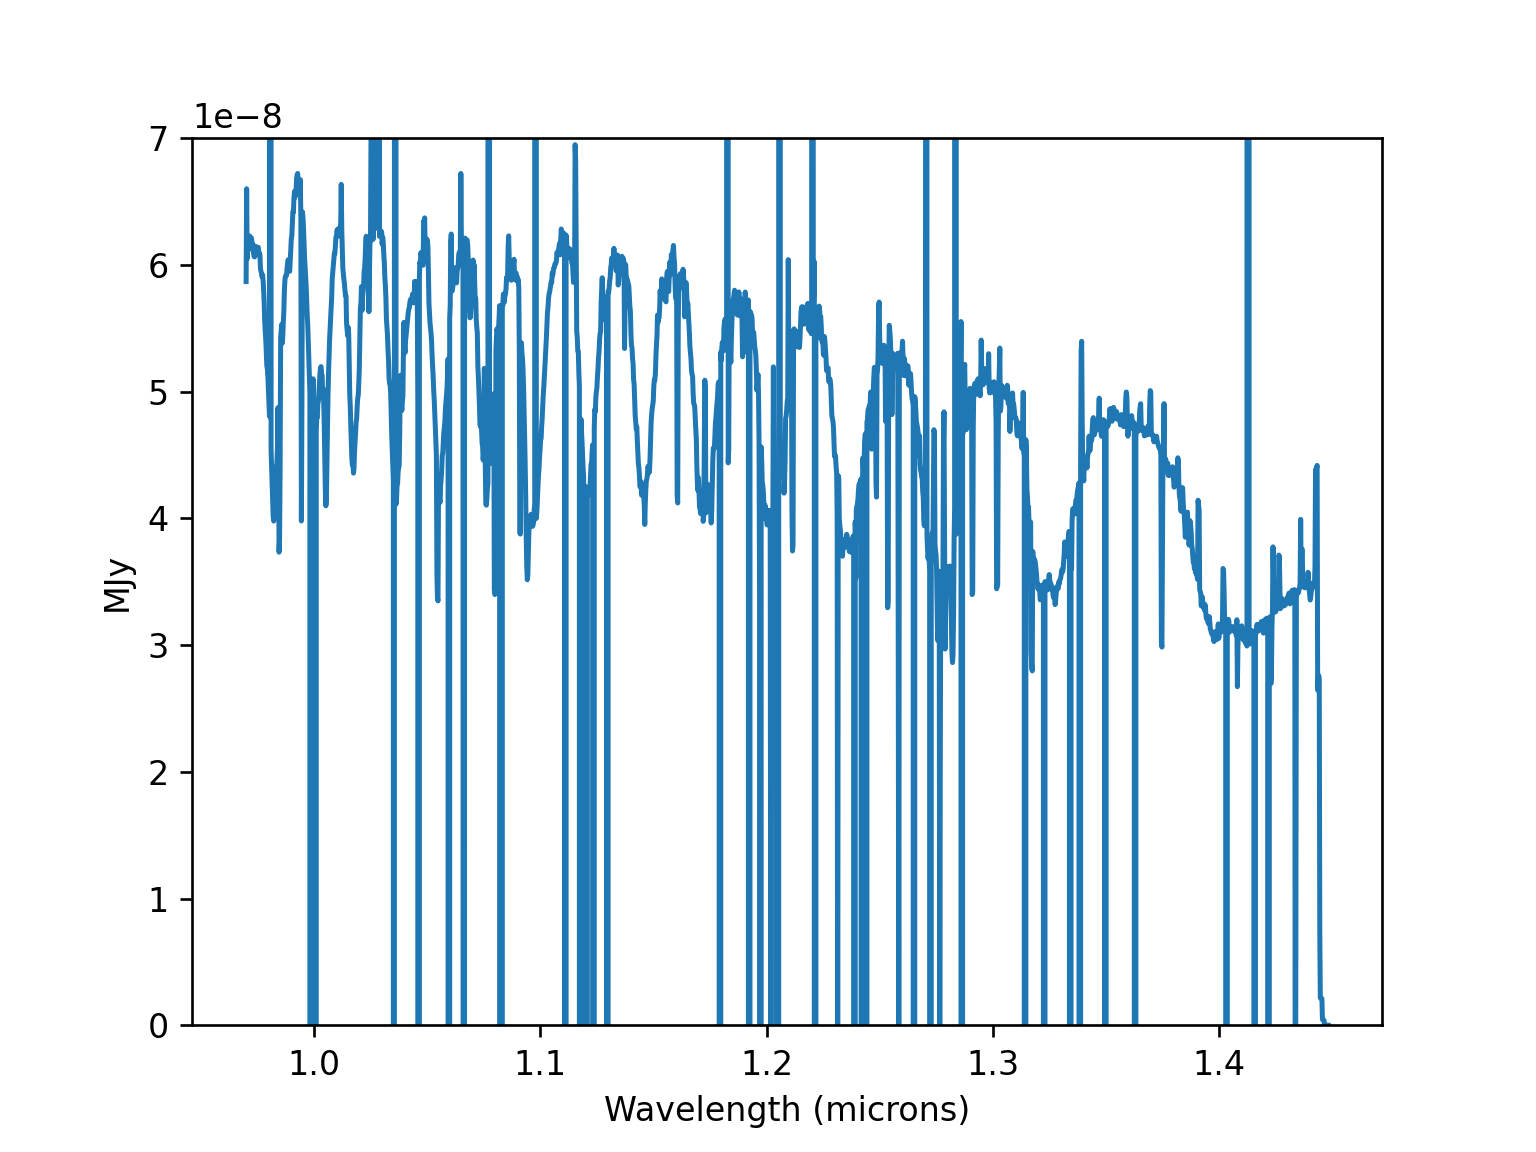

Text(0.5, 0, 'Wavelength (microns)')

In [55]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength1, flux1)
plt.show()
plt.ylim([0,.7e-7])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


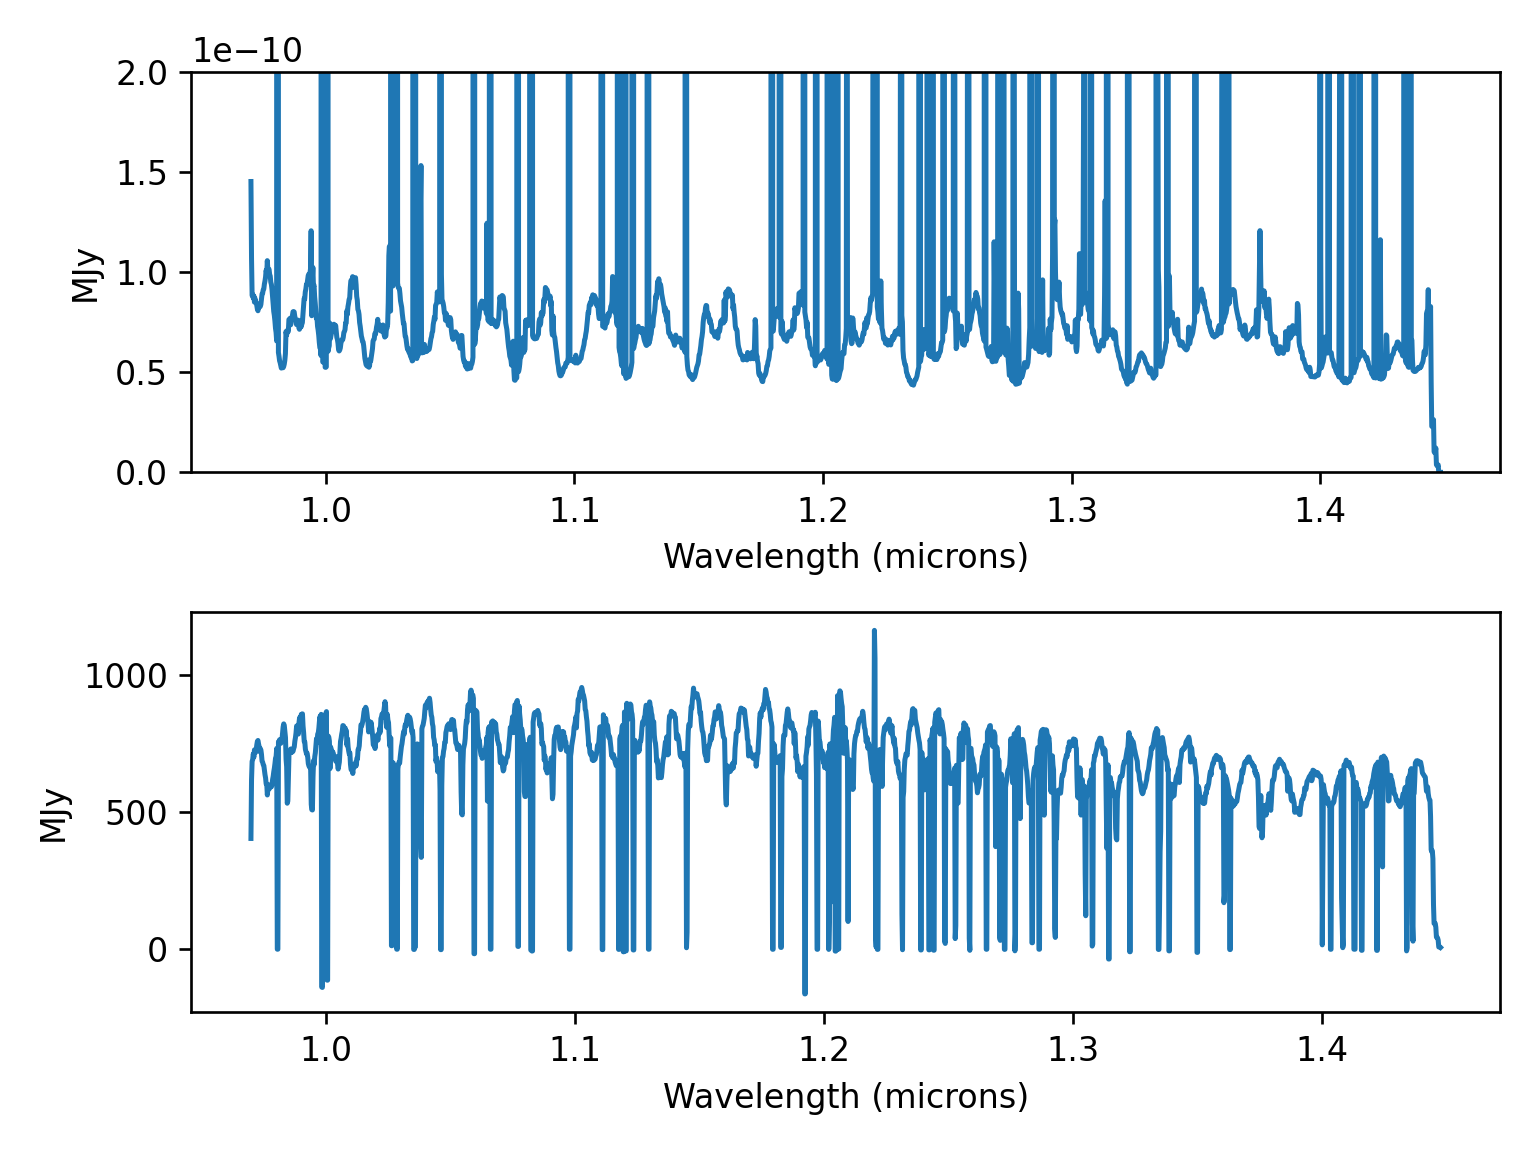

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/4002122417.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength1, flux1/error1)


In [56]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength1, error1)
plt.show()
plt.ylim([0,2e-10])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

plt.subplot(212)
plt.plot(wavelength1, flux1/error1)
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')
plt.tight_layout()

# DITHER 2

<IPython.core.display.Javascript object>


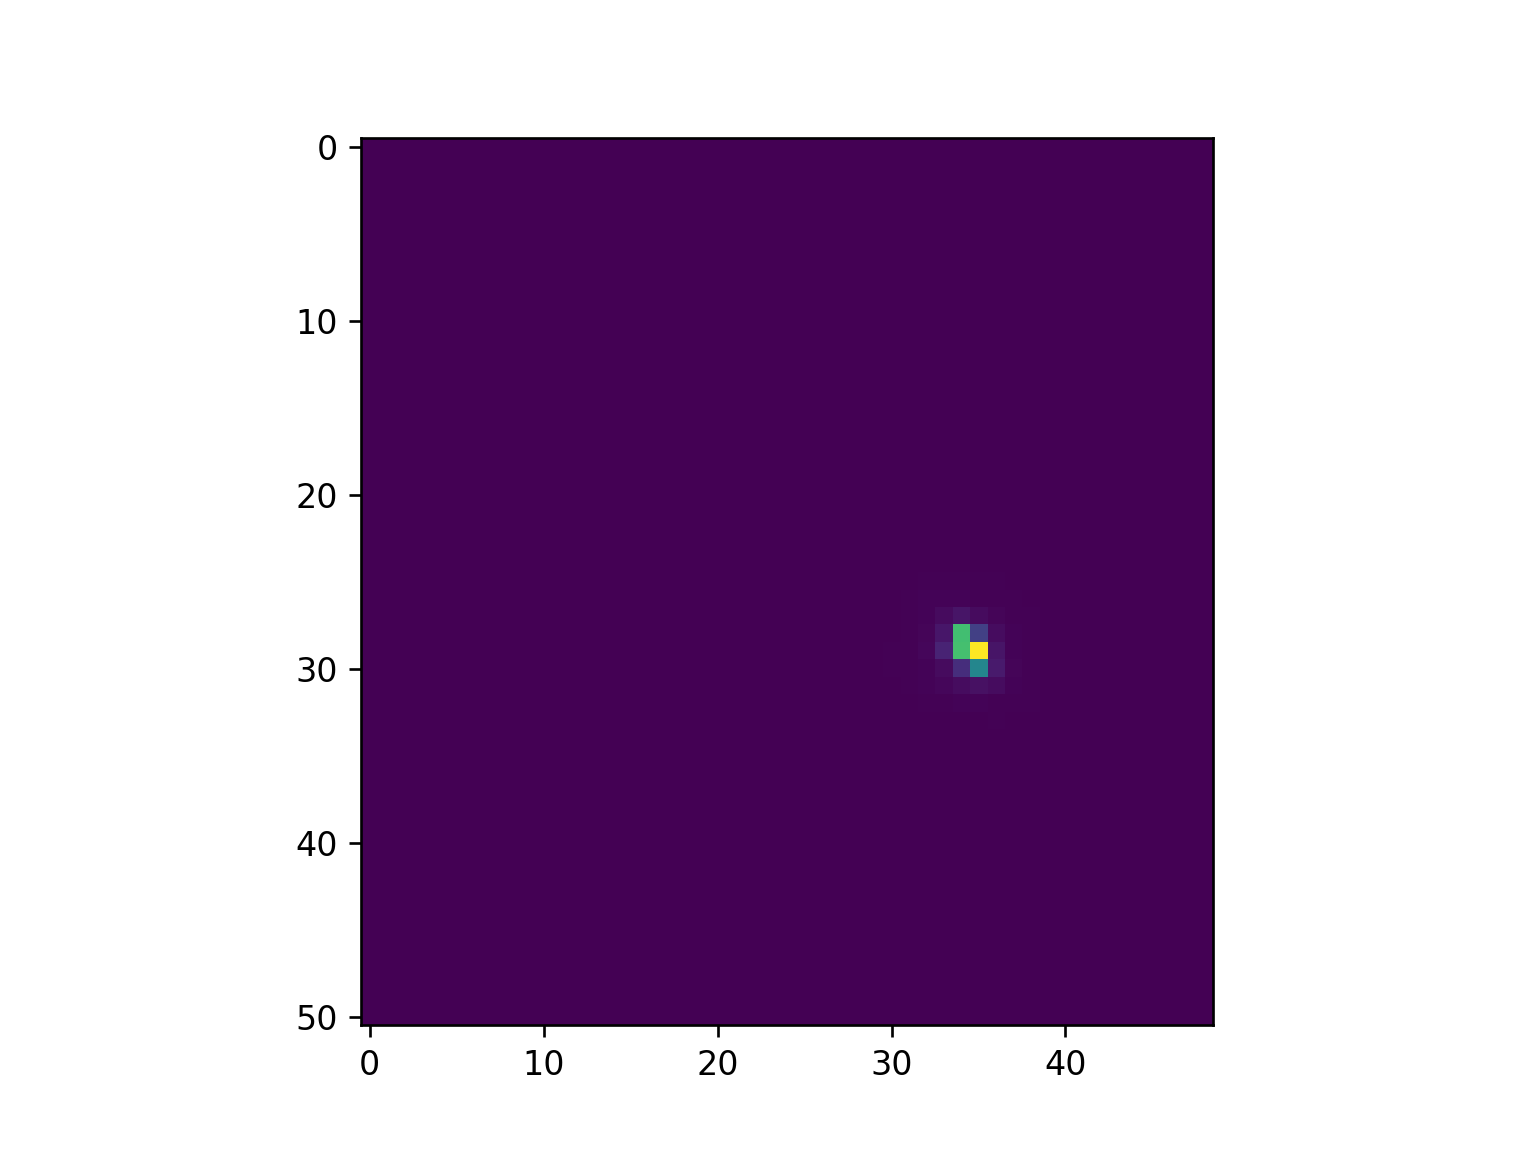

In [57]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse2/n.nanmax(cube_collapse2)))#, vmin = 0, vmax = 1e-9)
plt.show()

centroids (x, y)
34.523535229806846 28.897999130741606
sigmax, sigma y
1.0000000000317757 1.000000000042702


<IPython.core.display.Javascript object>


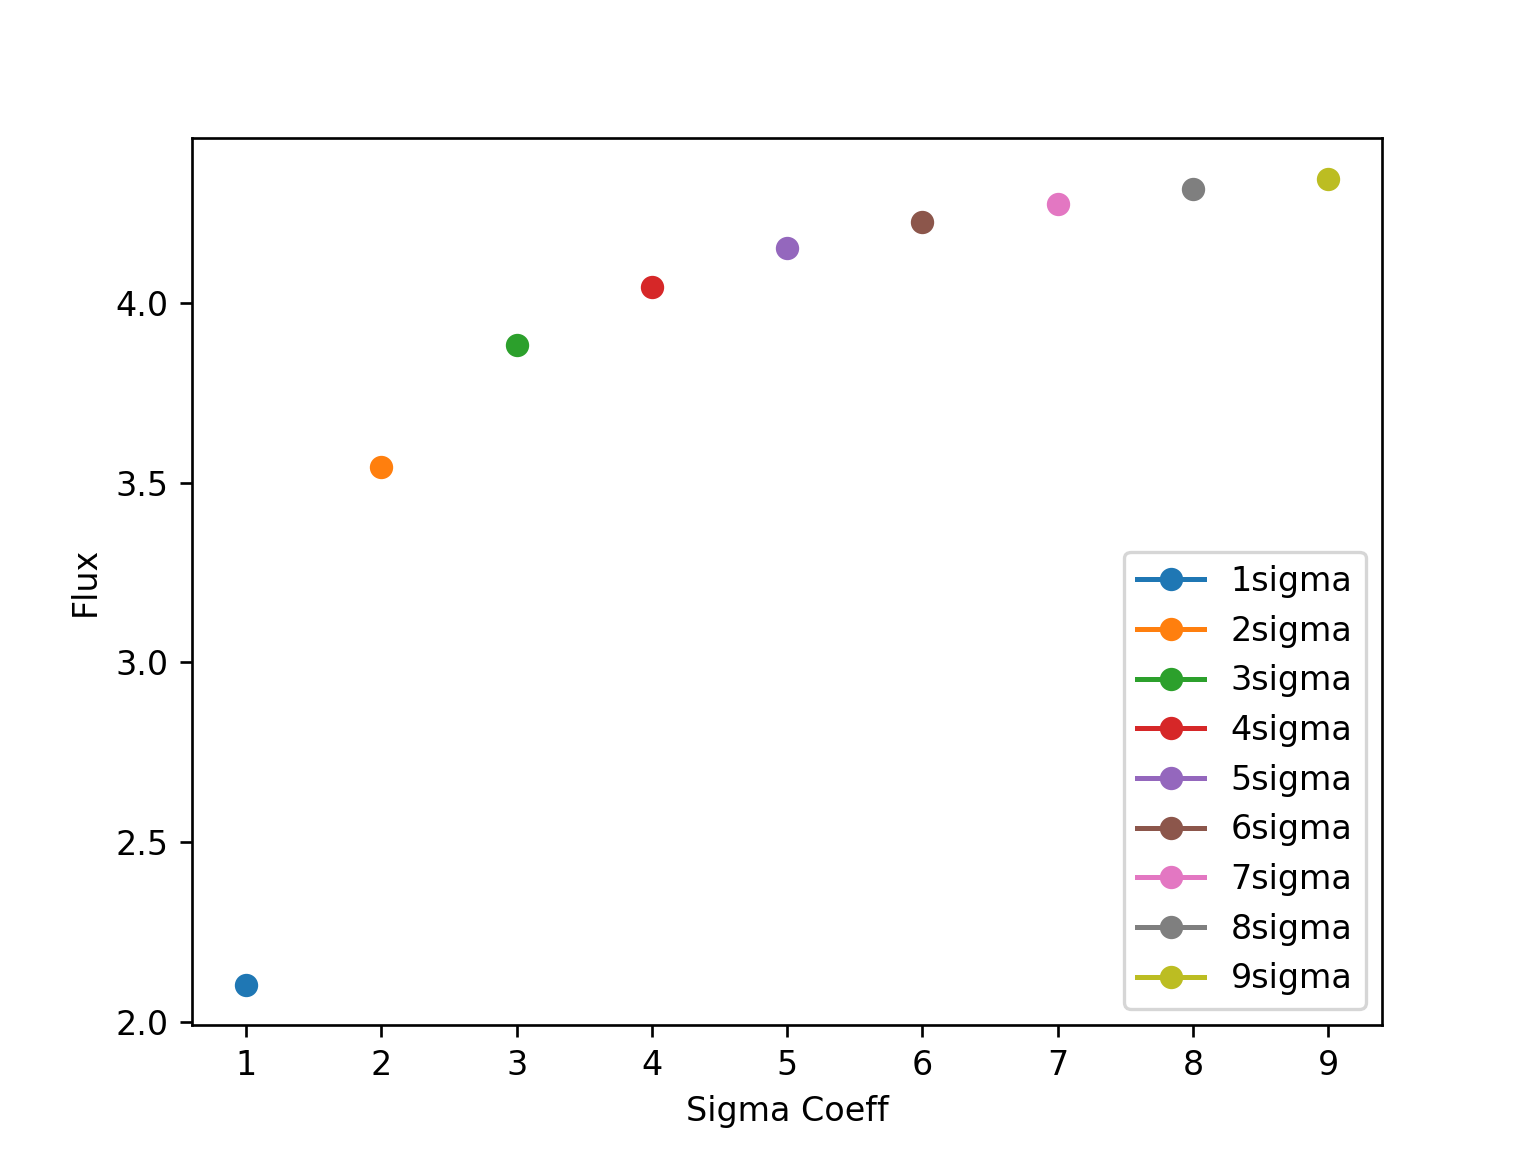

Text(0.5, 0, 'Sigma Coeff')

In [58]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse2/n.nanmax(cube_collapse2)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([35, 29, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [59]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data2.shape
flux2 = n.zeros(n_images)
error2 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data2[i]
    image_error = cube_data_err2[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux2[i] = flux_val 
    error2[i] = flux_val_err

<IPython.core.display.Javascript object>


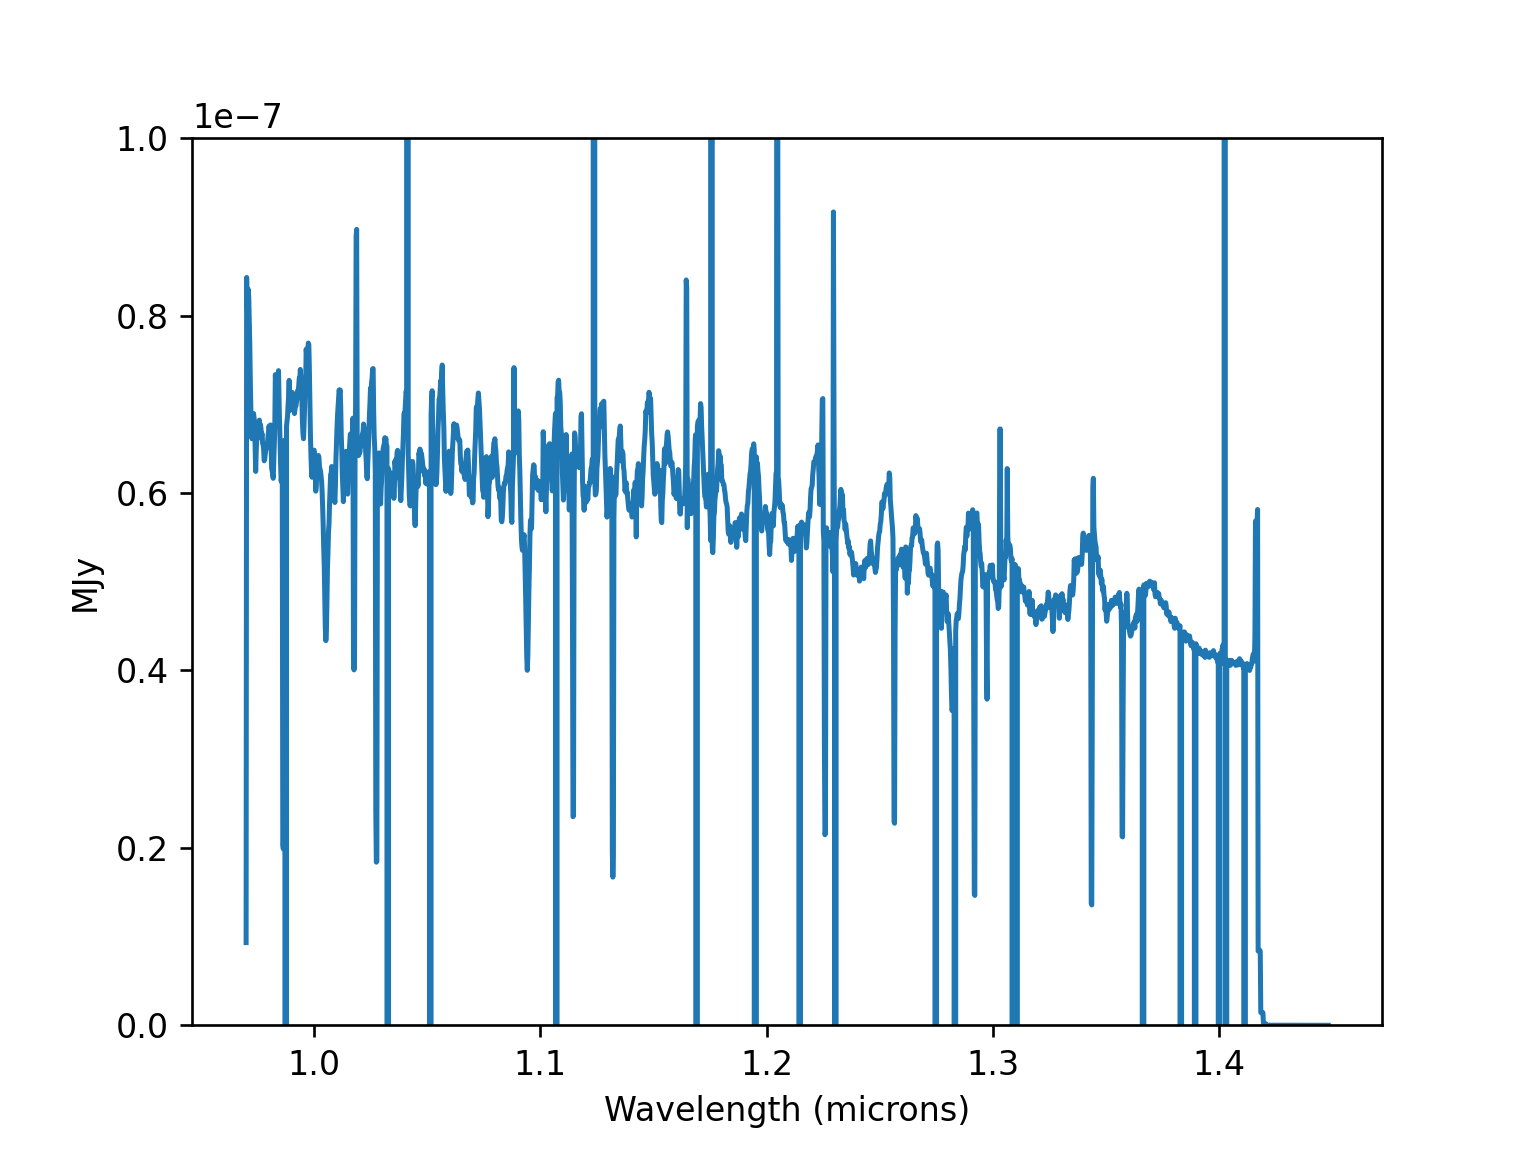

Text(0.5, 0, 'Wavelength (microns)')

In [60]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength2, flux2)
plt.show()
plt.ylim([0,1e-7])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


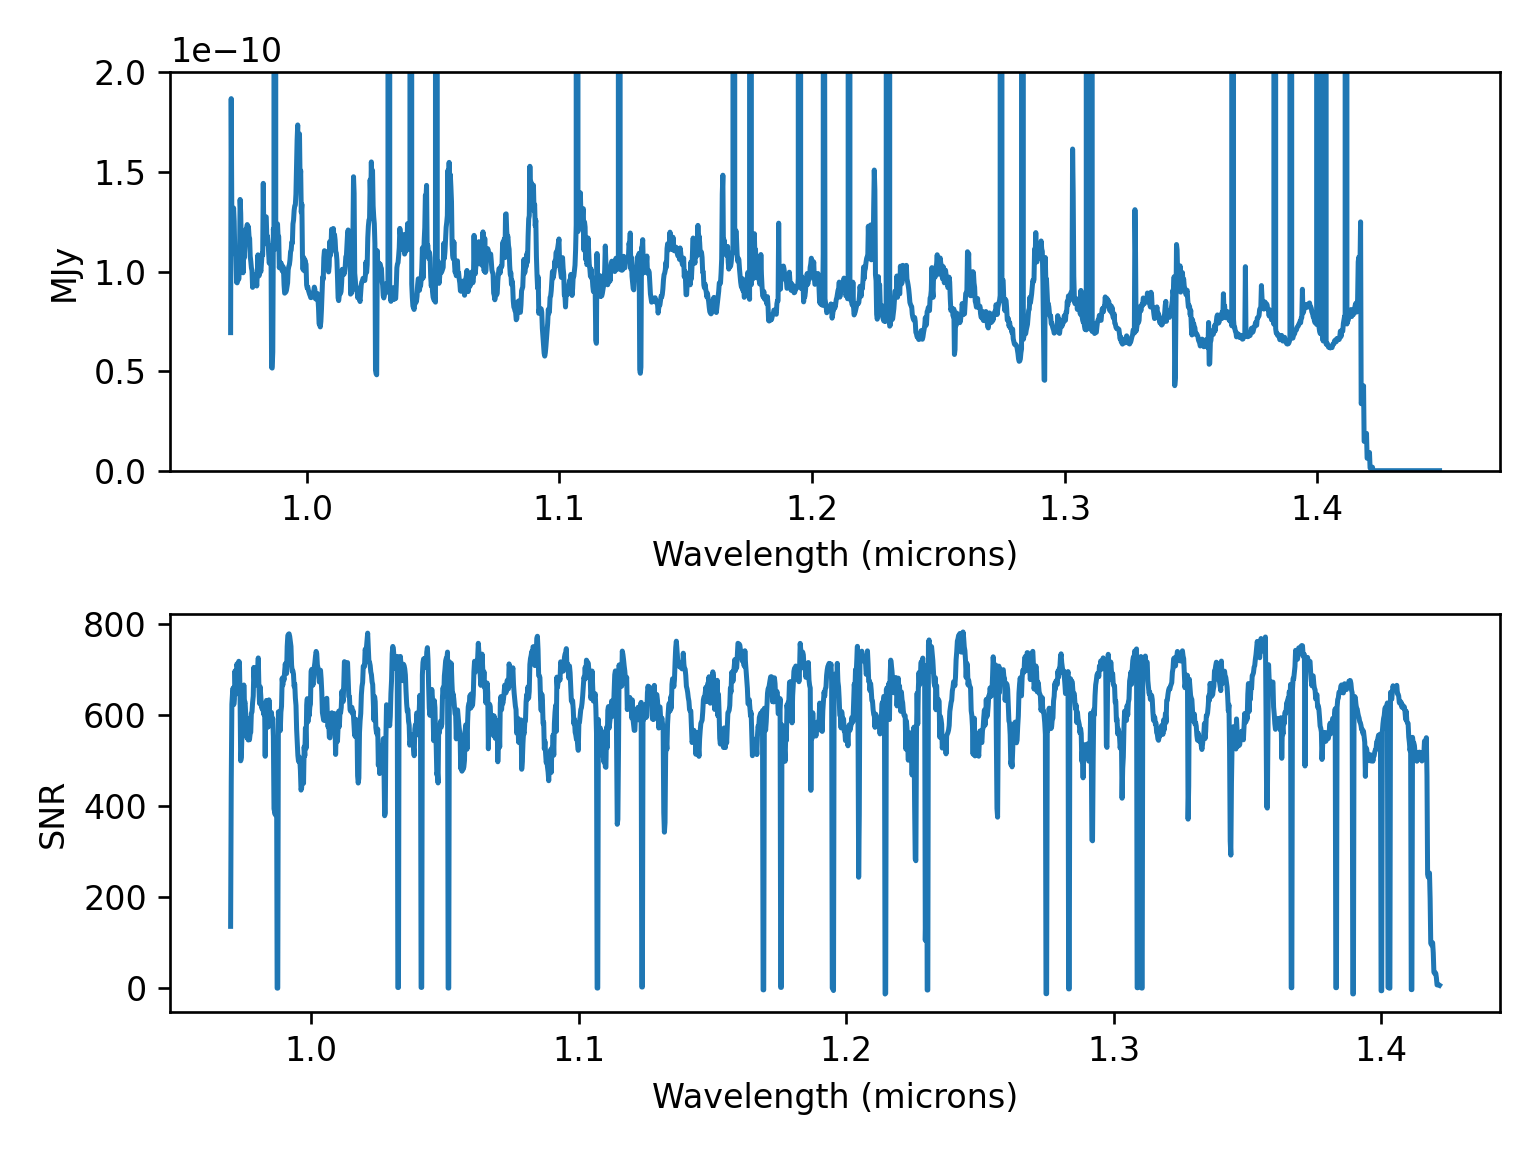

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/1004507361.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength2, flux2/error2)


In [61]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength2, error2)
plt.show()
plt.ylim([0,2e-10])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

plt.subplot(212)
plt.plot(wavelength2, flux2/error2)
plt.show()
plt.ylabel('SNR')
plt.xlabel('Wavelength (microns)')
plt.tight_layout()

# DITHER 3

<IPython.core.display.Javascript object>


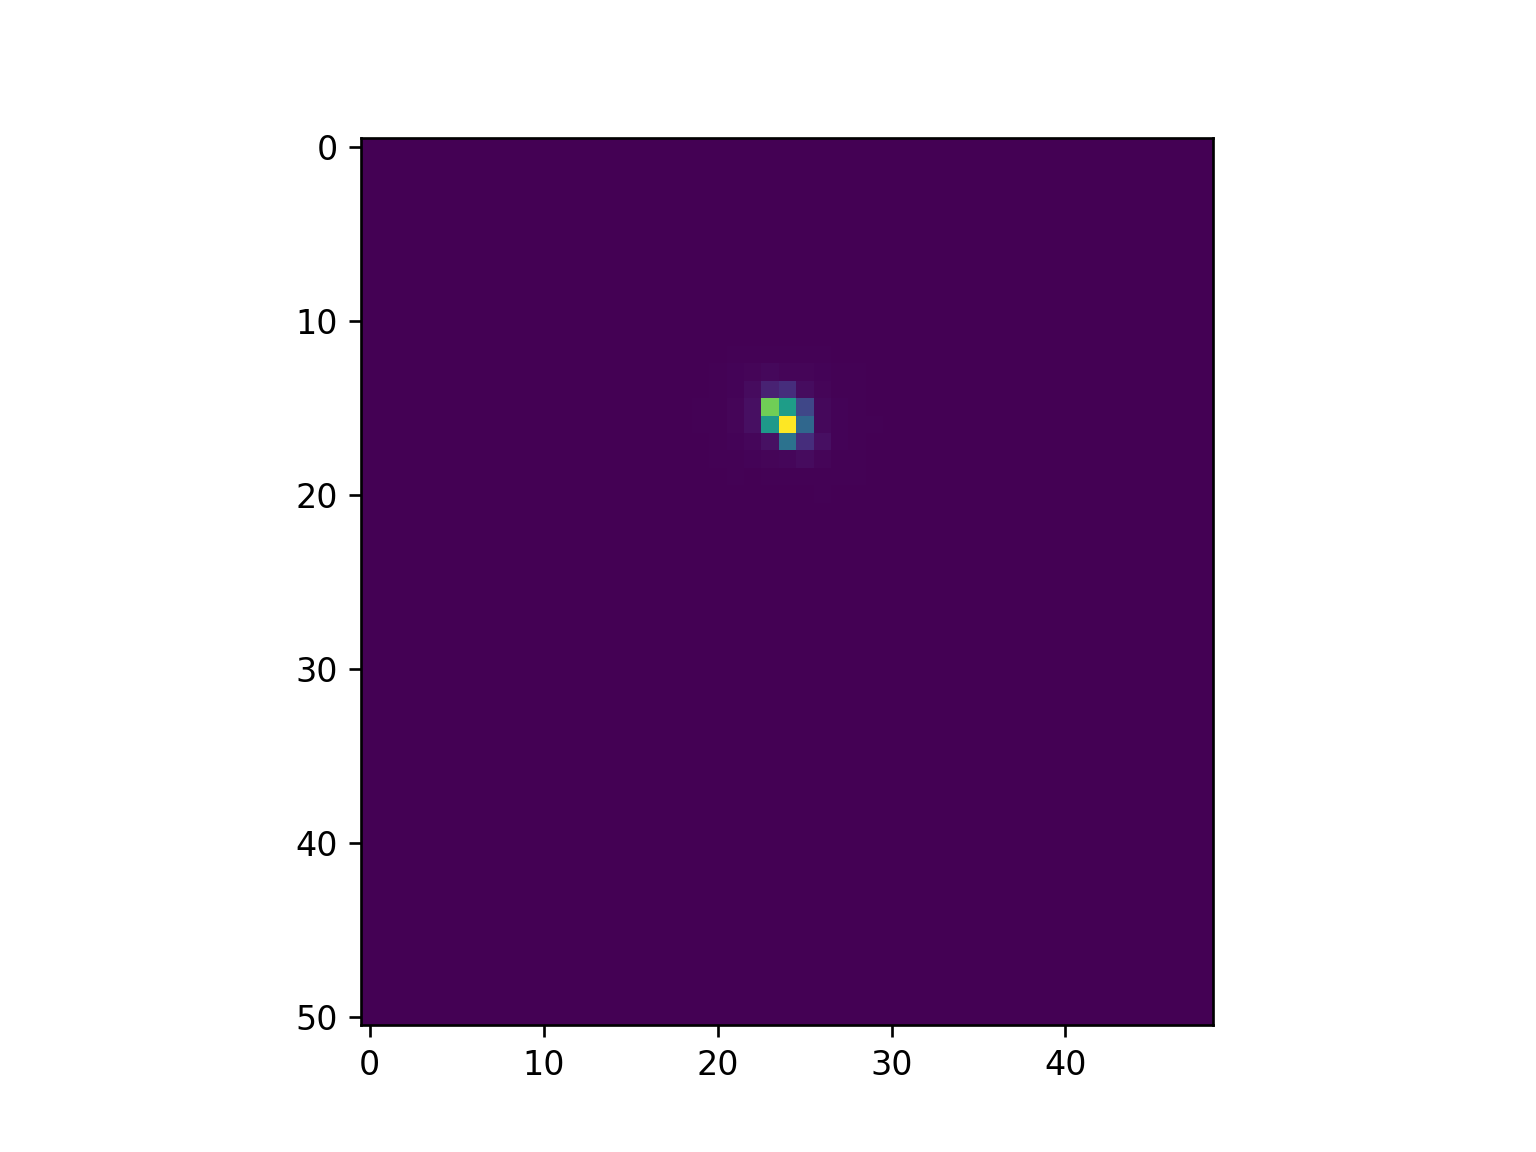

In [62]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse3/n.nanmax(cube_collapse3)))
plt.show()

centroids (x, y)
23.752886758265884 15.662340766863837
sigmax, sigma y
1.0000000000486502 1.0000000000537999


<IPython.core.display.Javascript object>


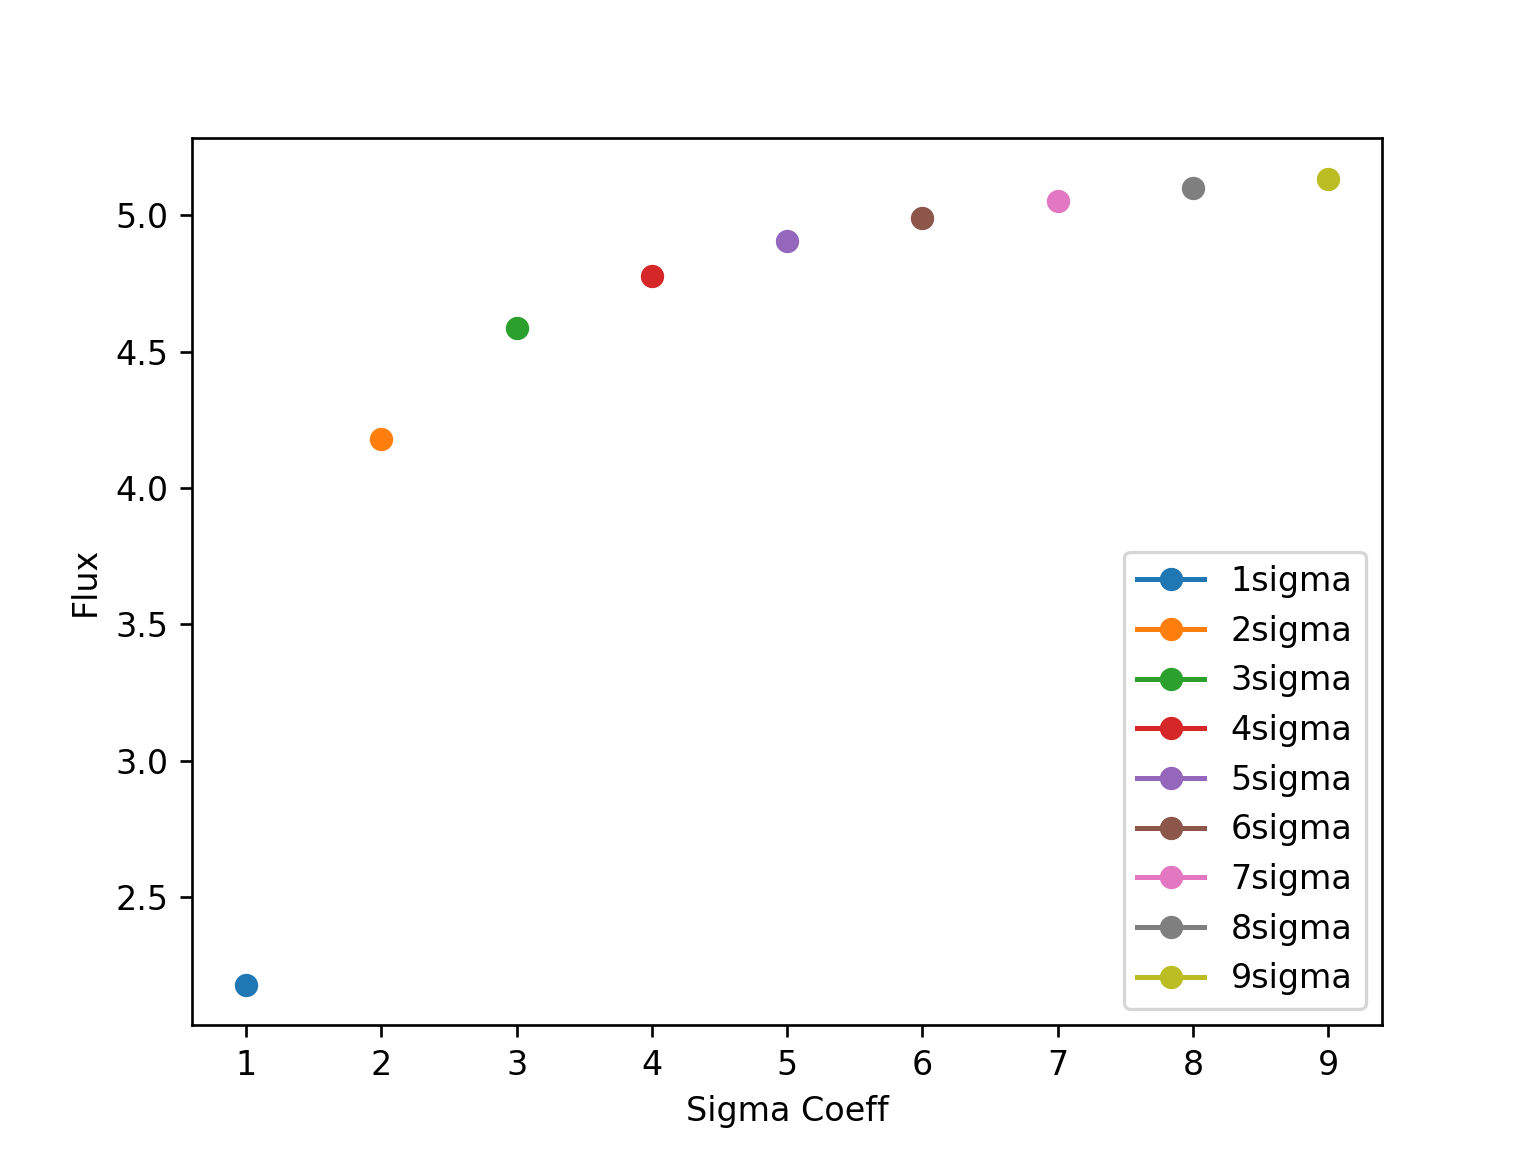

Text(0.5, 0, 'Sigma Coeff')

In [63]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse3/n.nanmax(cube_collapse3)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([24, 16., n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)


plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [64]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data3.shape
flux3 = n.zeros(n_images)
error3 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data3[i]
    image_error = cube_data_err3[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux3[i] = flux_val 
    error3[i] = flux_val_err

<IPython.core.display.Javascript object>


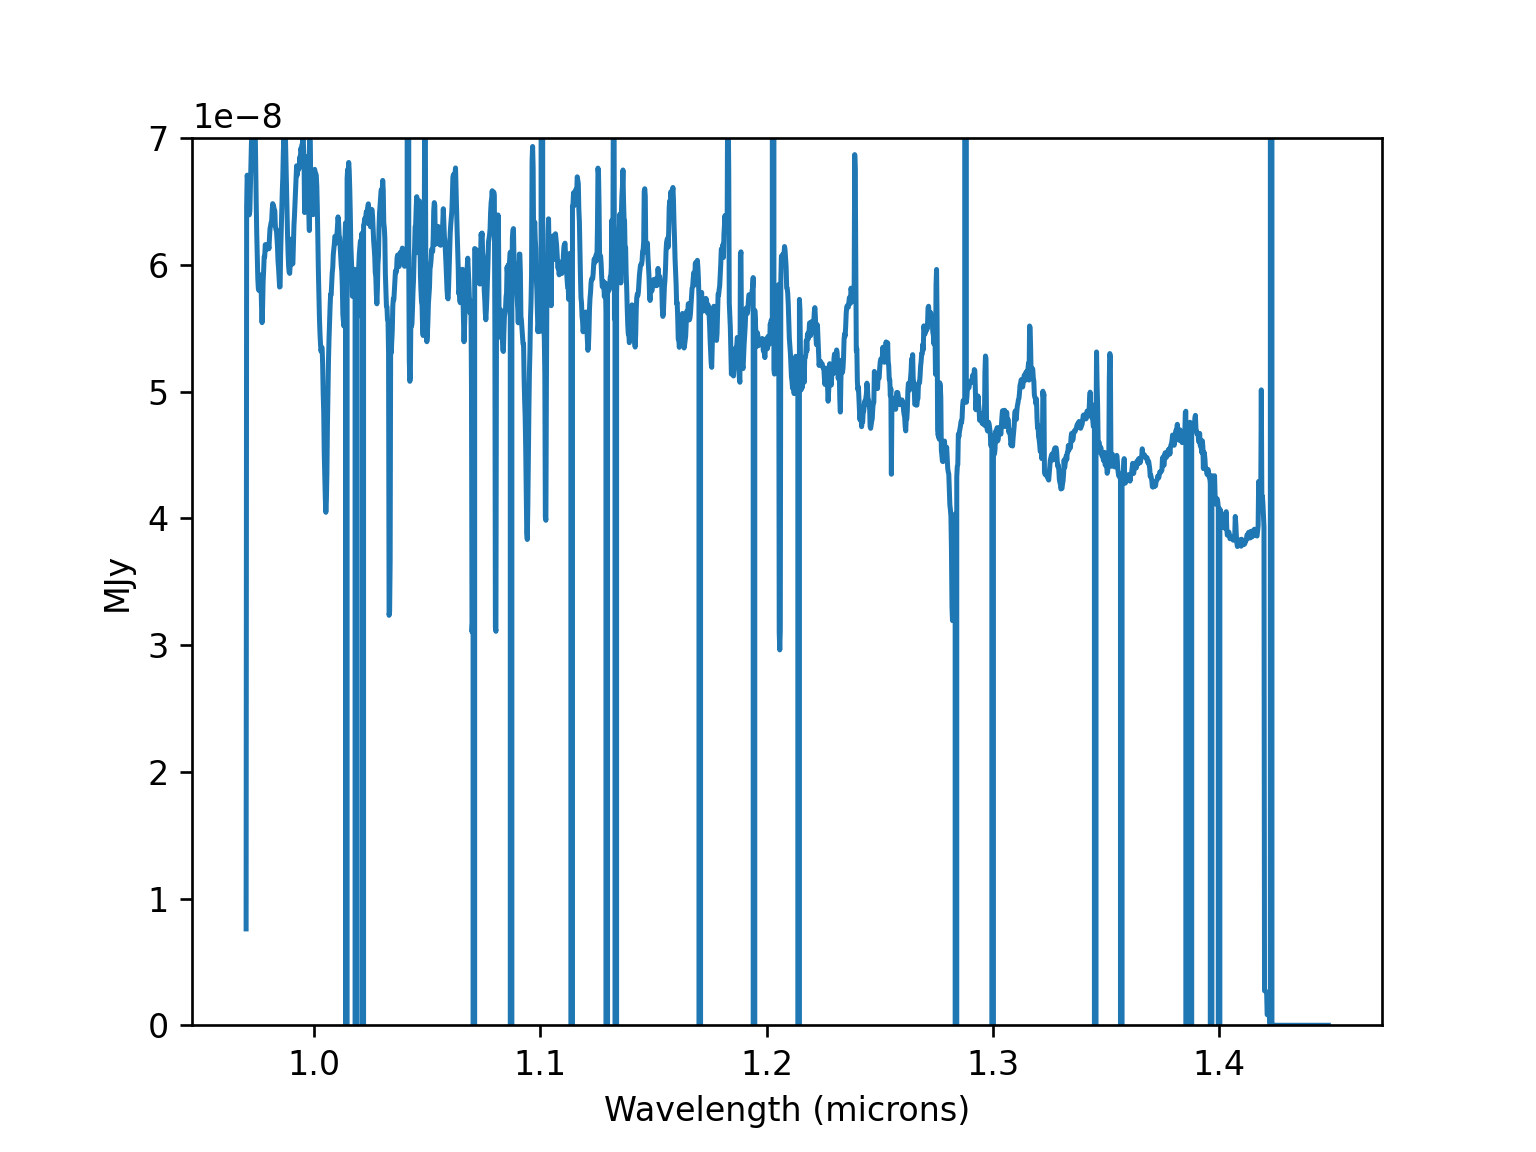

Text(0.5, 0, 'Wavelength (microns)')

In [65]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength3, flux3)
plt.show()
plt.ylim([0,.7e-7])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


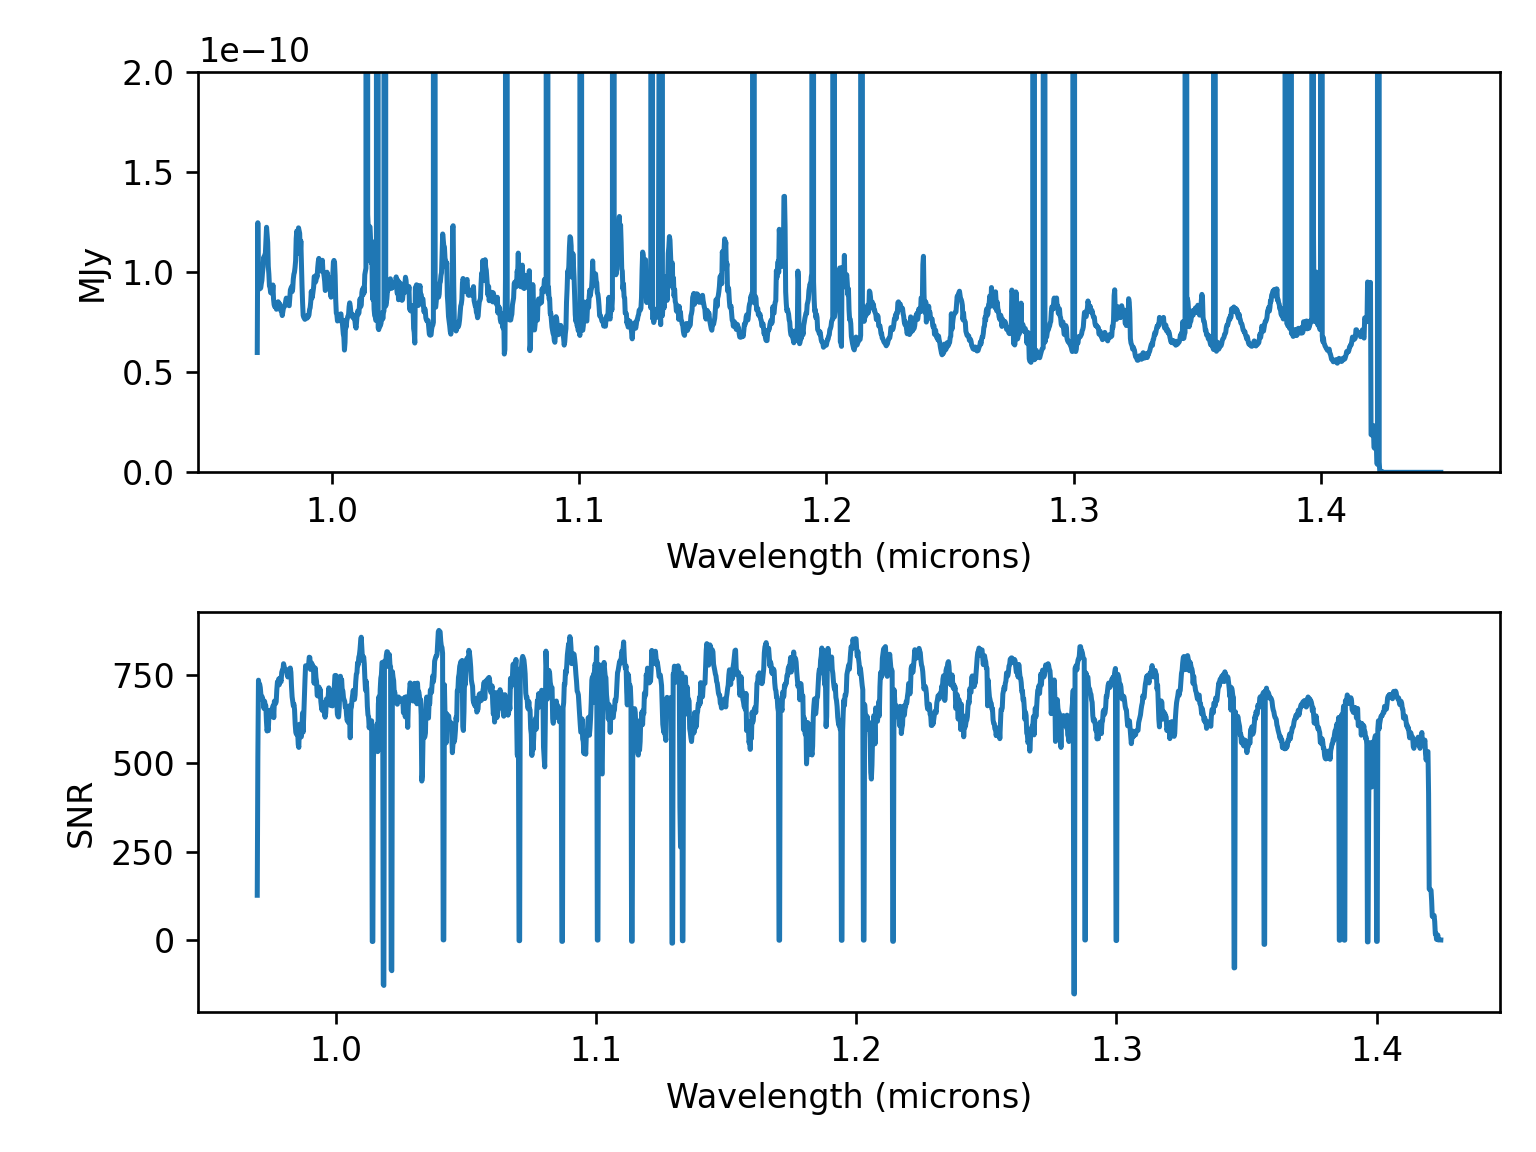

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/236900794.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength3, flux3/error3)


In [66]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength3, error3)
plt.ylim([0,2e-10])
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

plt.subplot(212)
plt.plot(wavelength3, flux3/error3)
plt.show()
plt.ylabel('SNR')
plt.xlabel('Wavelength (microns)')
plt.tight_layout()

# DITHER 4

<IPython.core.display.Javascript object>


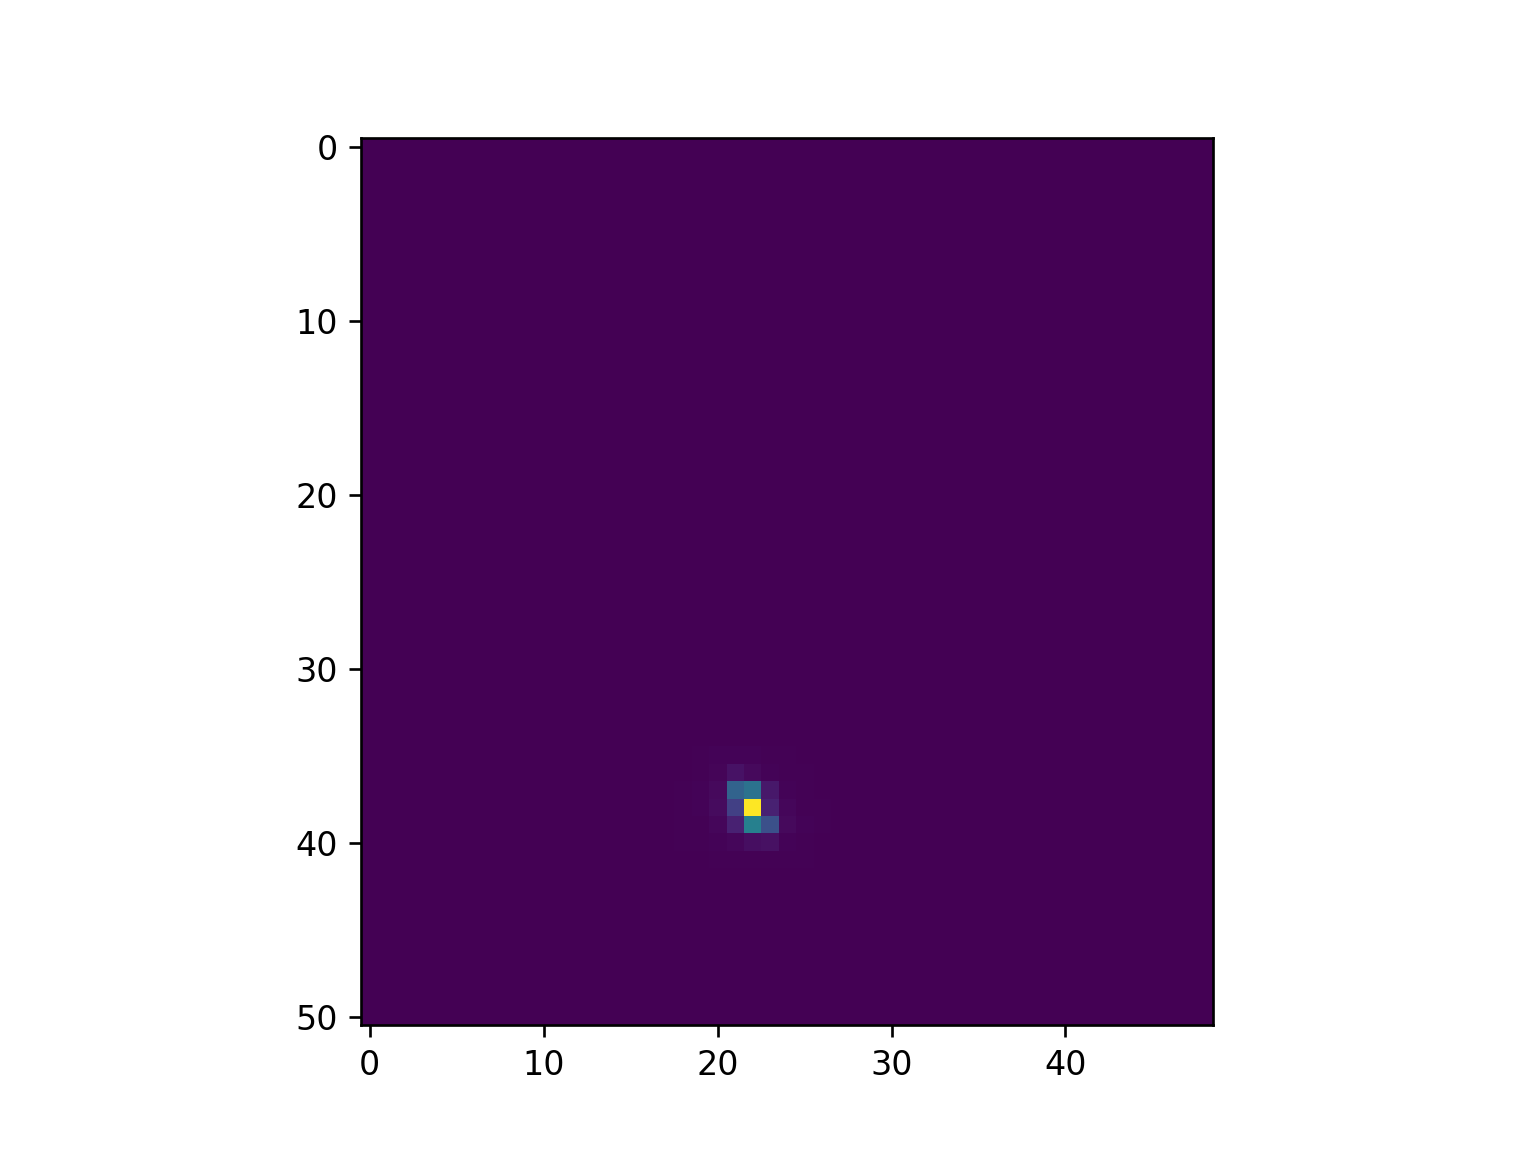

In [67]:
%matplotlib notebook
plt.figure('collapsed cube')
plt.imshow((cube_collapse4/n.nanmax(cube_collapse4)))
plt.show()

centroids (x, y)
21.93162861144614 38.007725176957926
sigmax, sigma y
1.0000000000251048 1.00000000005883


<IPython.core.display.Javascript object>


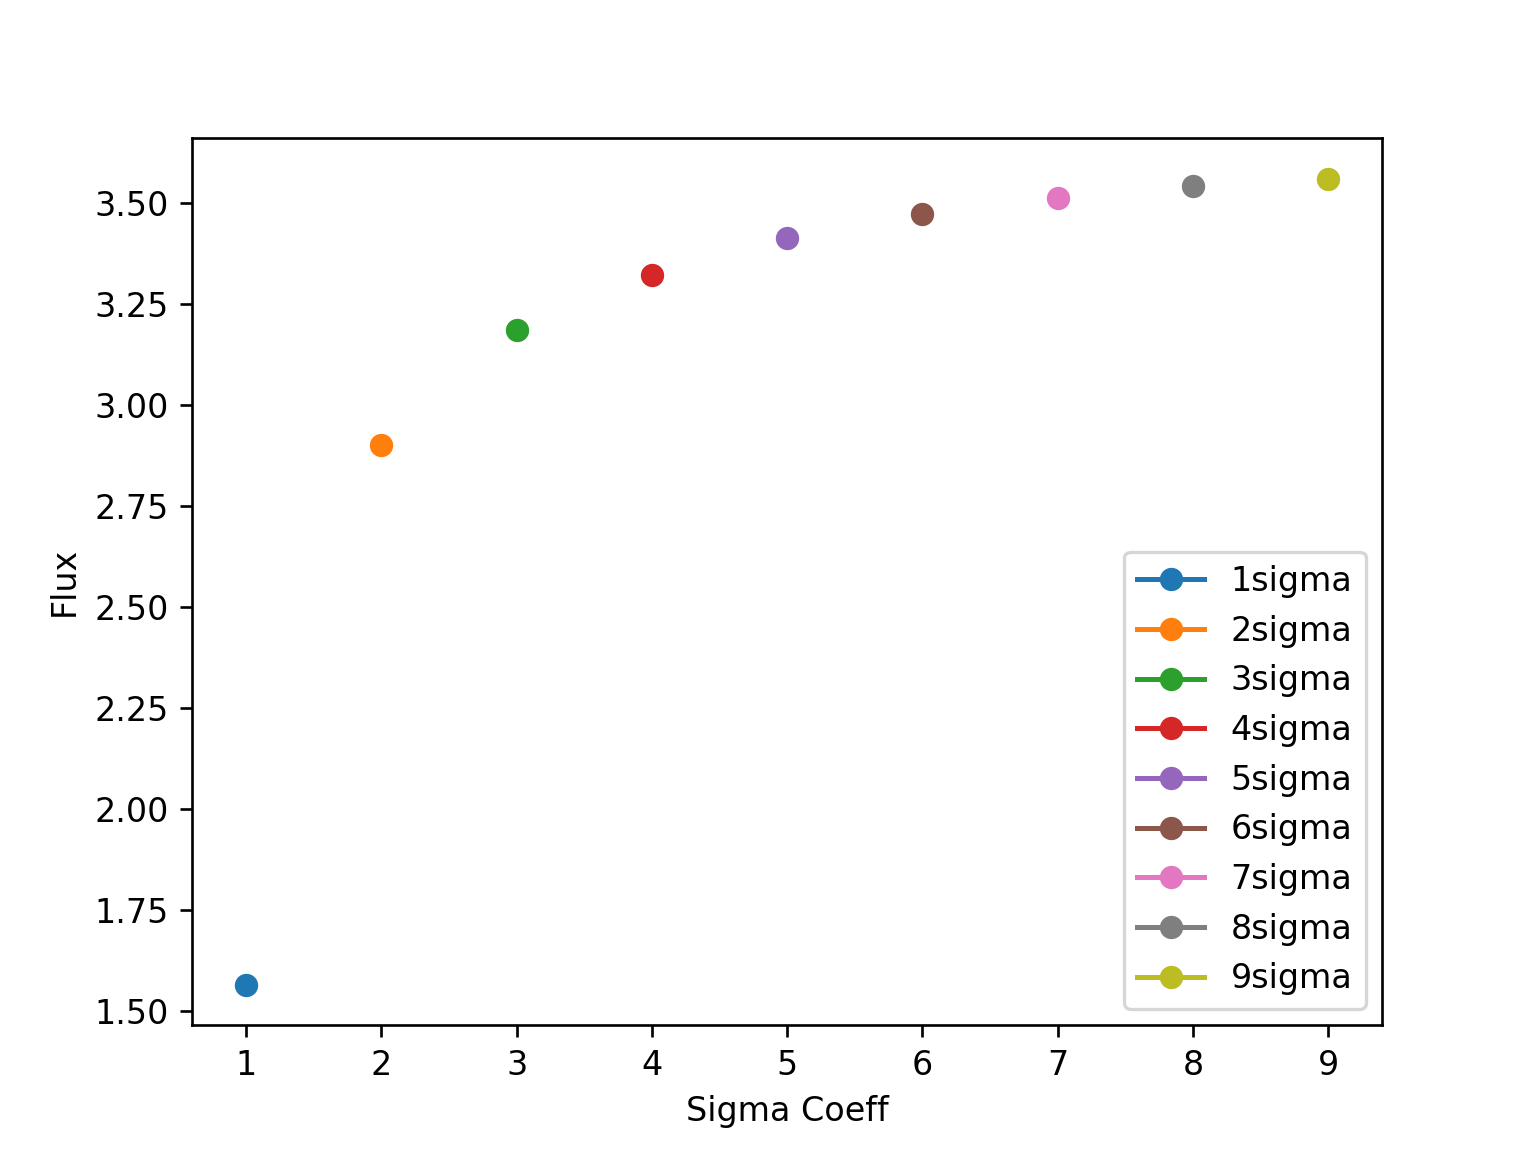

Text(0.5, 0, 'Sigma Coeff')

In [68]:
## fitting a gaussian to the collapsed cube which is a median image to remove high pixels
image = cube_collapse4/n.nanmax(cube_collapse4)
y_len, x_len = image.shape
bounds = ((0, 0, n.nanmin(image), 1, 1, n.nanmedian(image)) , (x_len, y_len, n.nanmax(image), x_len, y_len, 2 * n.nanmax(image)) )
guess = n.array([22, 38, n.nanmin(image), 1, 1, n.nanmax(image)])
fit_arr = optimize.least_squares(image_solve, guess, args = (image,), bounds = bounds )#, bounds=bounds)
x0_fit, y0_fit, offset_fit, sigma_x_fit, sigma_y_fit, A_fit = fit_arr.x

print('centroids (x, y)')
print(x0_fit, y0_fit)
print('sigmax, sigma y')
print(sigma_x_fit, sigma_y_fit)

plt.figure('Flux vs Aperture radius')
sigma_coeffs = n.arange(1,10)

for sigma_coeff in sigma_coeffs:

    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coeff, sigma_y_fit * sigma_coeff)  # science image extraction
    phot_table = aperture_photometry(image, aperture)
    flux_val = phot_table['aperture_sum'].data

        
    plt.plot(sigma_coeff, flux_val, marker ='o', label = str(sigma_coeff) + 'sigma')

plt.legend()
plt.show()
plt.ylabel('Flux')
plt.xlabel('Sigma Coeff')

In [69]:
sigma_coef_val = 3
n_images, y_dim, x_dim =  cube_data4.shape
flux4 = n.zeros(n_images)
error4 = n.zeros(n_images)
bg = n.zeros(n_images)

for i in n.arange(0,n_images):
    
    image = cube_data4[i]
    image_error = cube_data_err4[i]
    
    aperture = EllipticalAperture((x0_fit, y0_fit), sigma_x_fit * sigma_coef_val, sigma_y_fit * sigma_coef_val)  # science image extraction
    phot_table = aperture_photometry(image, aperture, error = image_error) #error
    flux_val = phot_table['aperture_sum'].data
    flux_val_err = phot_table['aperture_sum_err'].data
    
    area = aperture.area
    
    flux4[i] = flux_val 
    error4[i] = flux_val_err

<IPython.core.display.Javascript object>


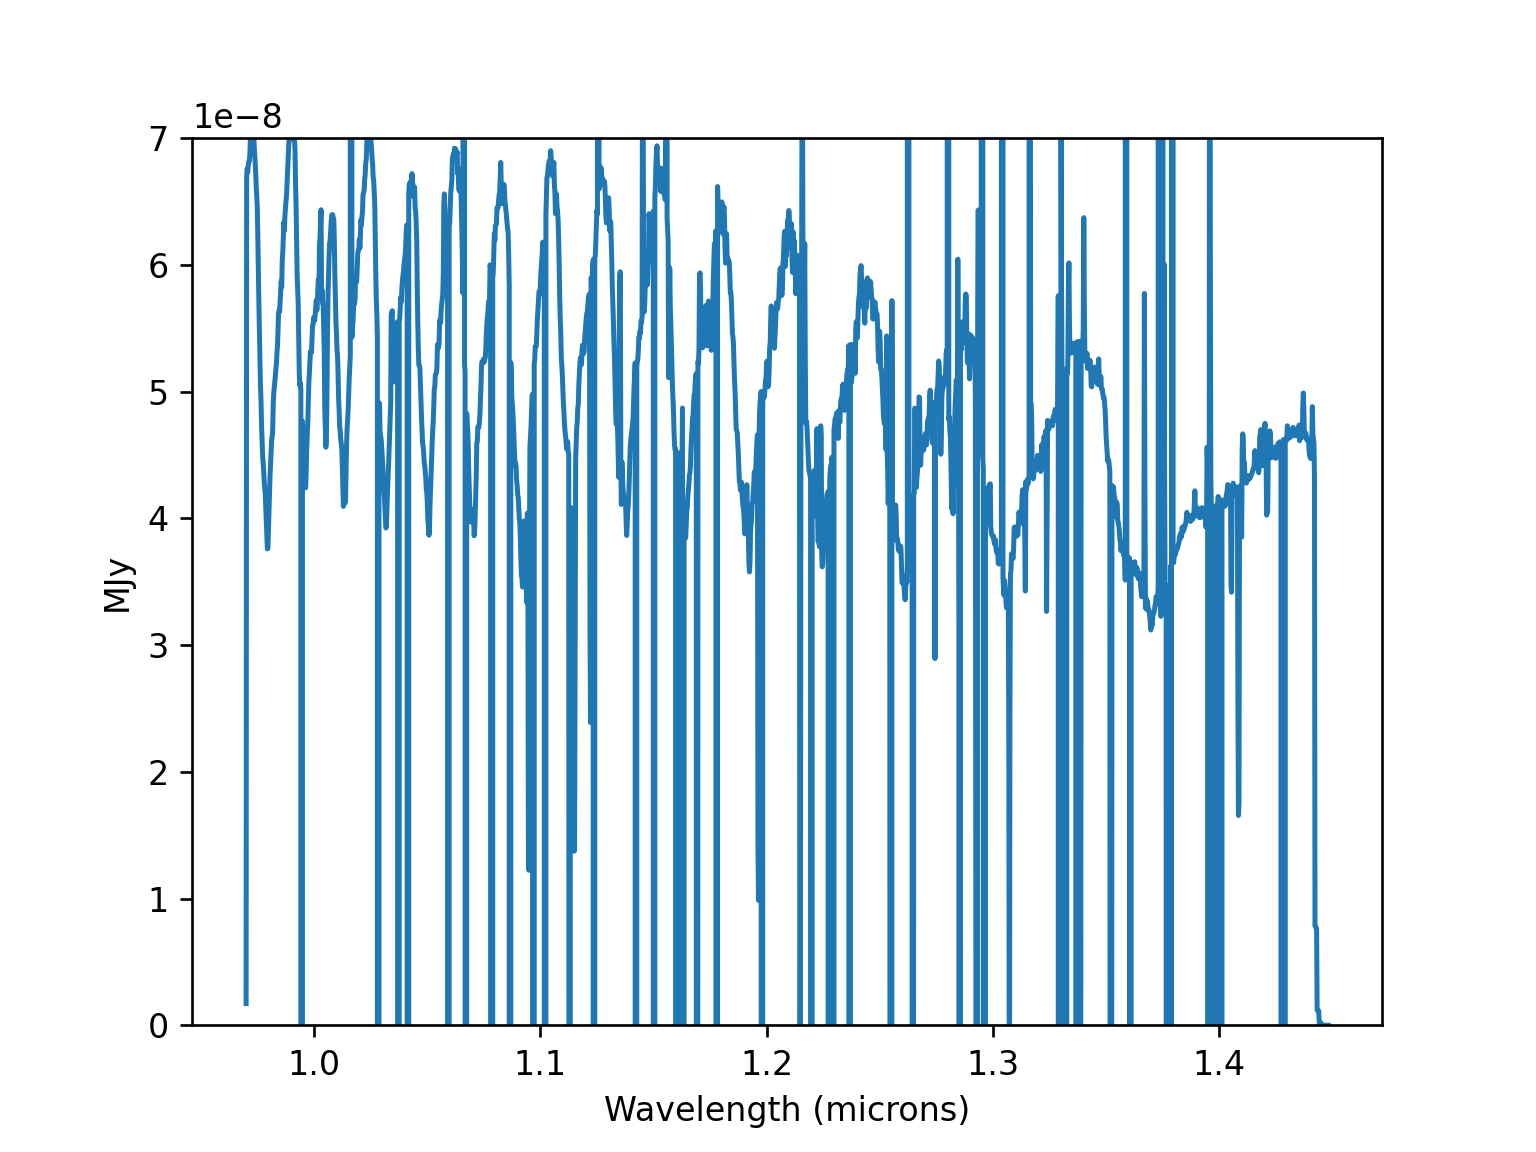

Text(0.5, 0, 'Wavelength (microns)')

In [70]:
%matplotlib notebook
plt.figure('spectra')
plt.plot(wavelength4, flux4)
plt.show()
plt.ylim([0,.7e-7])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


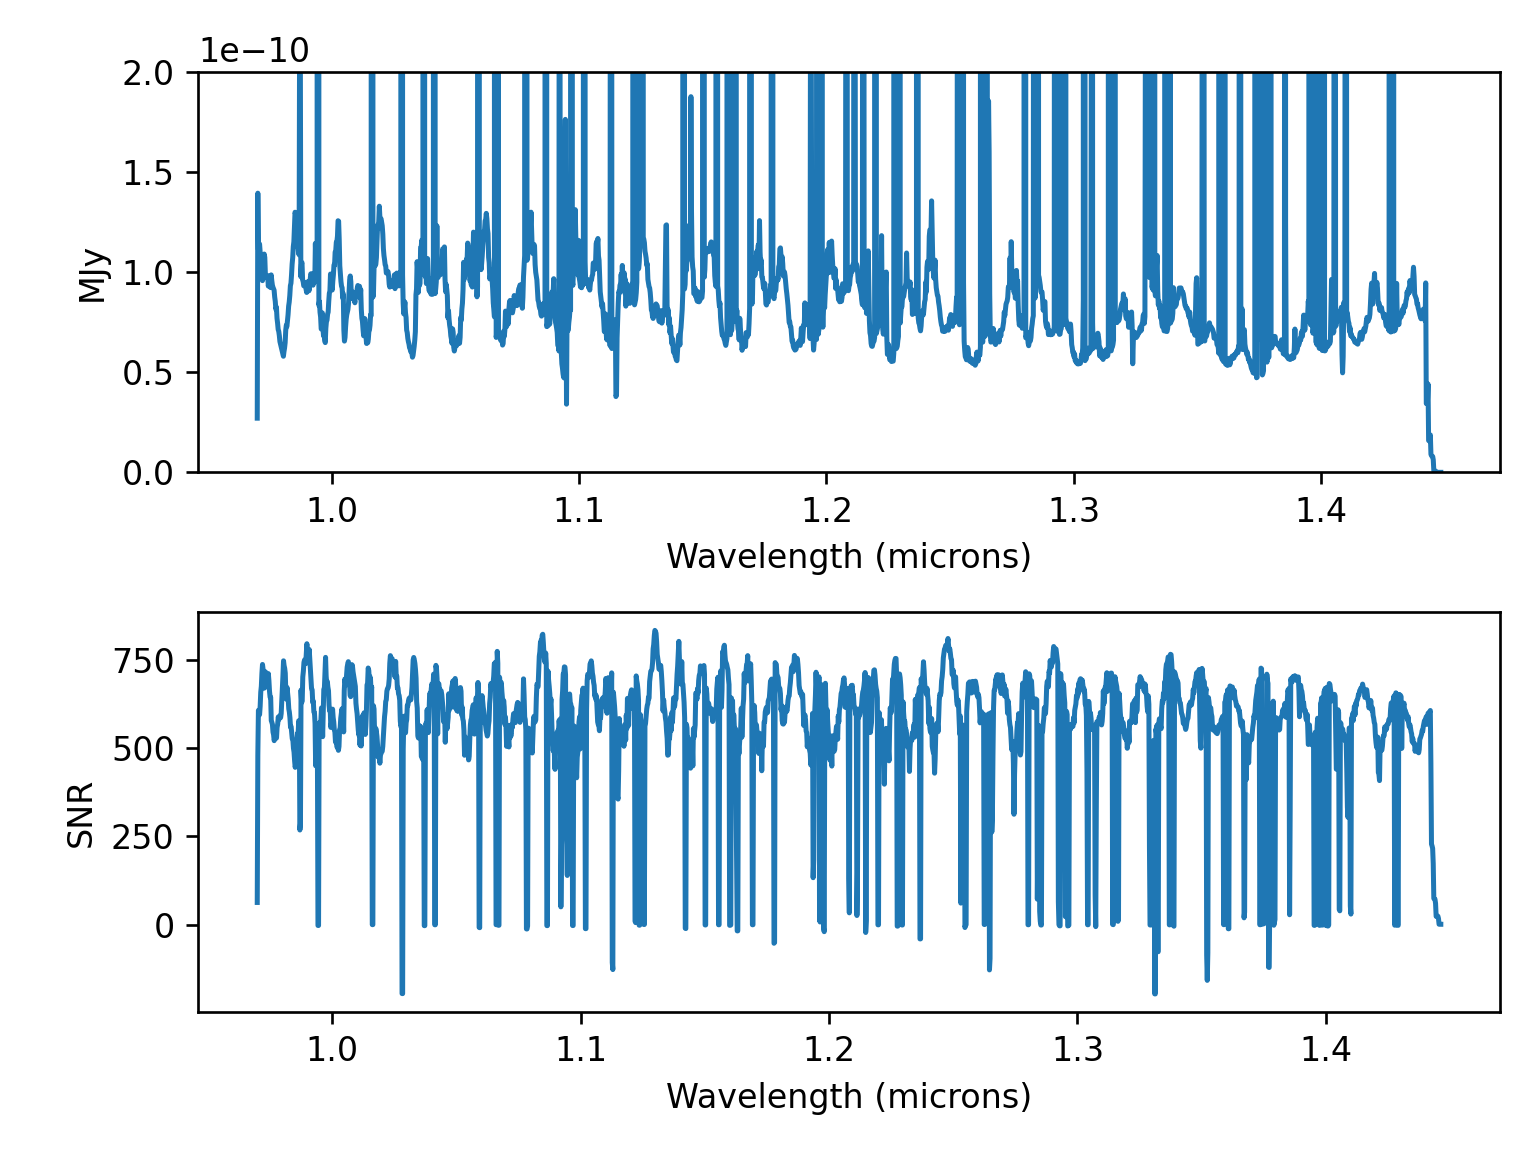

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/4074018112.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(wavelength4, flux4/error4)


In [71]:
%matplotlib notebook
plt.figure('spectra and snr')
plt.subplot(211)
plt.plot(wavelength4, error4)
plt.ylim([0,2e-10])
plt.show()
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

plt.subplot(212)
plt.plot(wavelength4, flux4/error4)
plt.show()
plt.ylabel('SNR')
plt.xlabel('Wavelength (microns)')
plt.tight_layout()

<IPython.core.display.Javascript object>


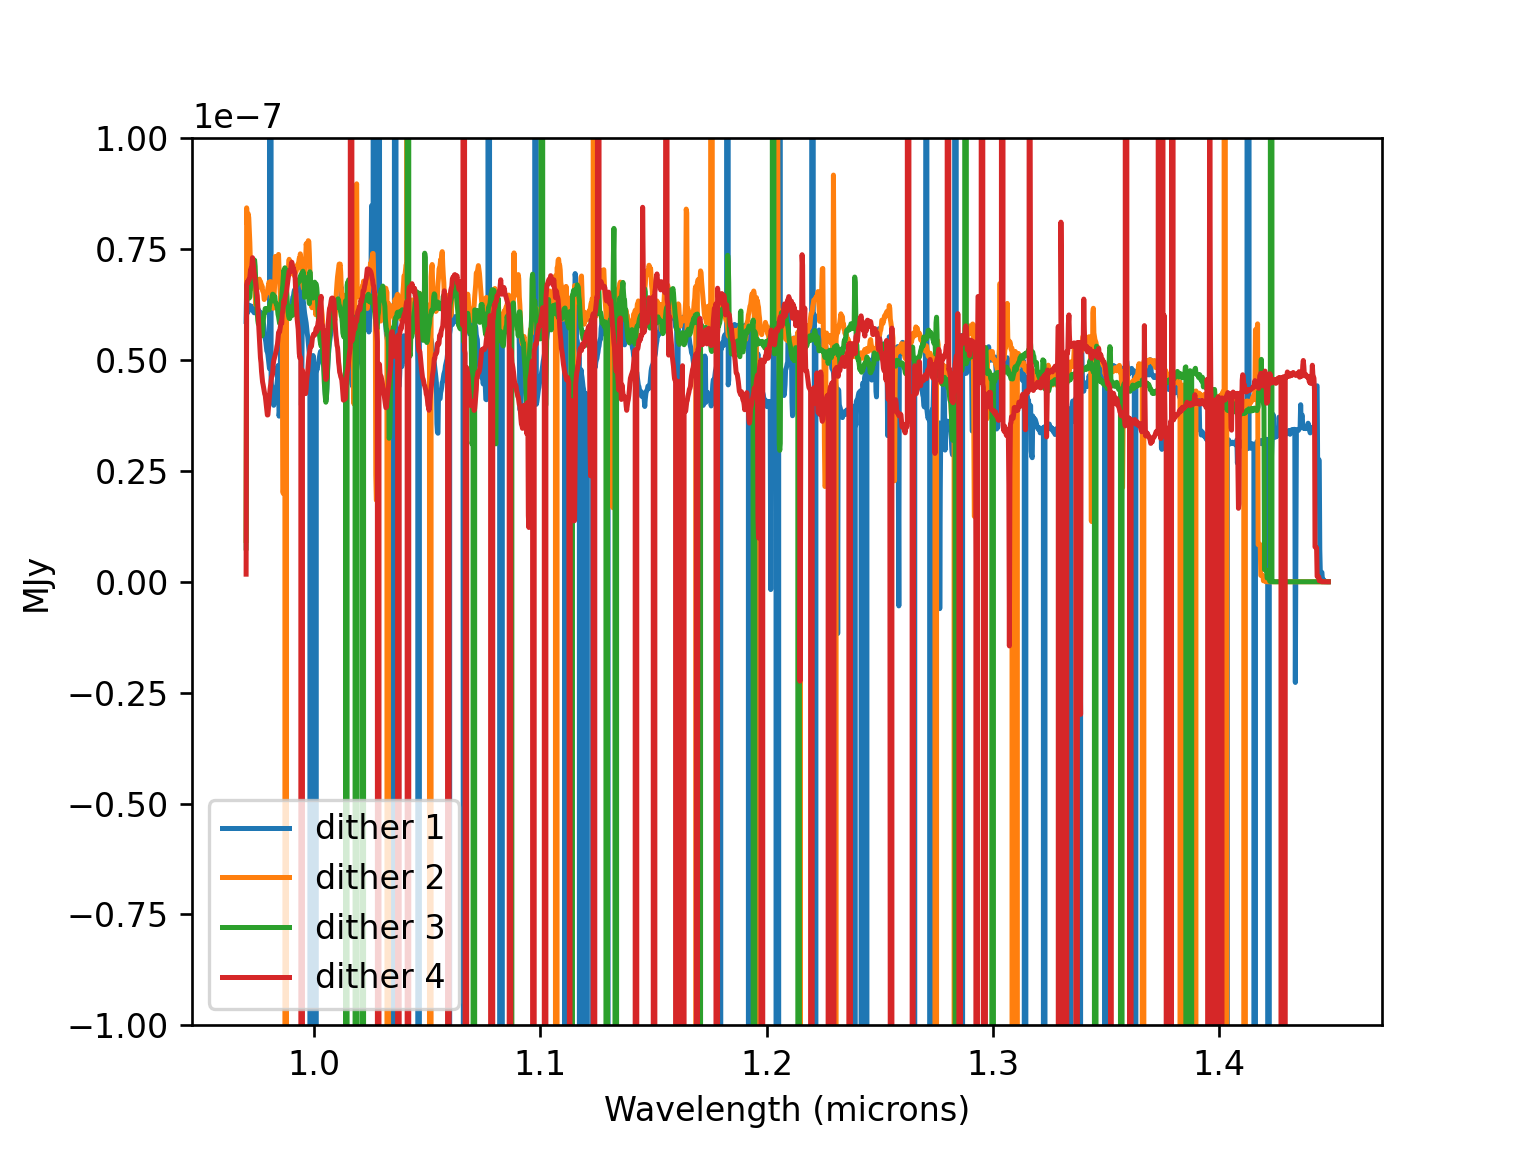

Text(0.5, 0, 'Wavelength (microns)')

In [72]:
%matplotlib notebook
plt.plot(wavelength1, flux1, label = 'dither 1')
plt.plot(wavelength2, flux2, label = 'dither 2')
plt.plot(wavelength3, flux3, label = 'dither 3')
plt.plot(wavelength4, flux4, label = 'dither 4')
plt.legend()
plt.ylim([-10e-8,10e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


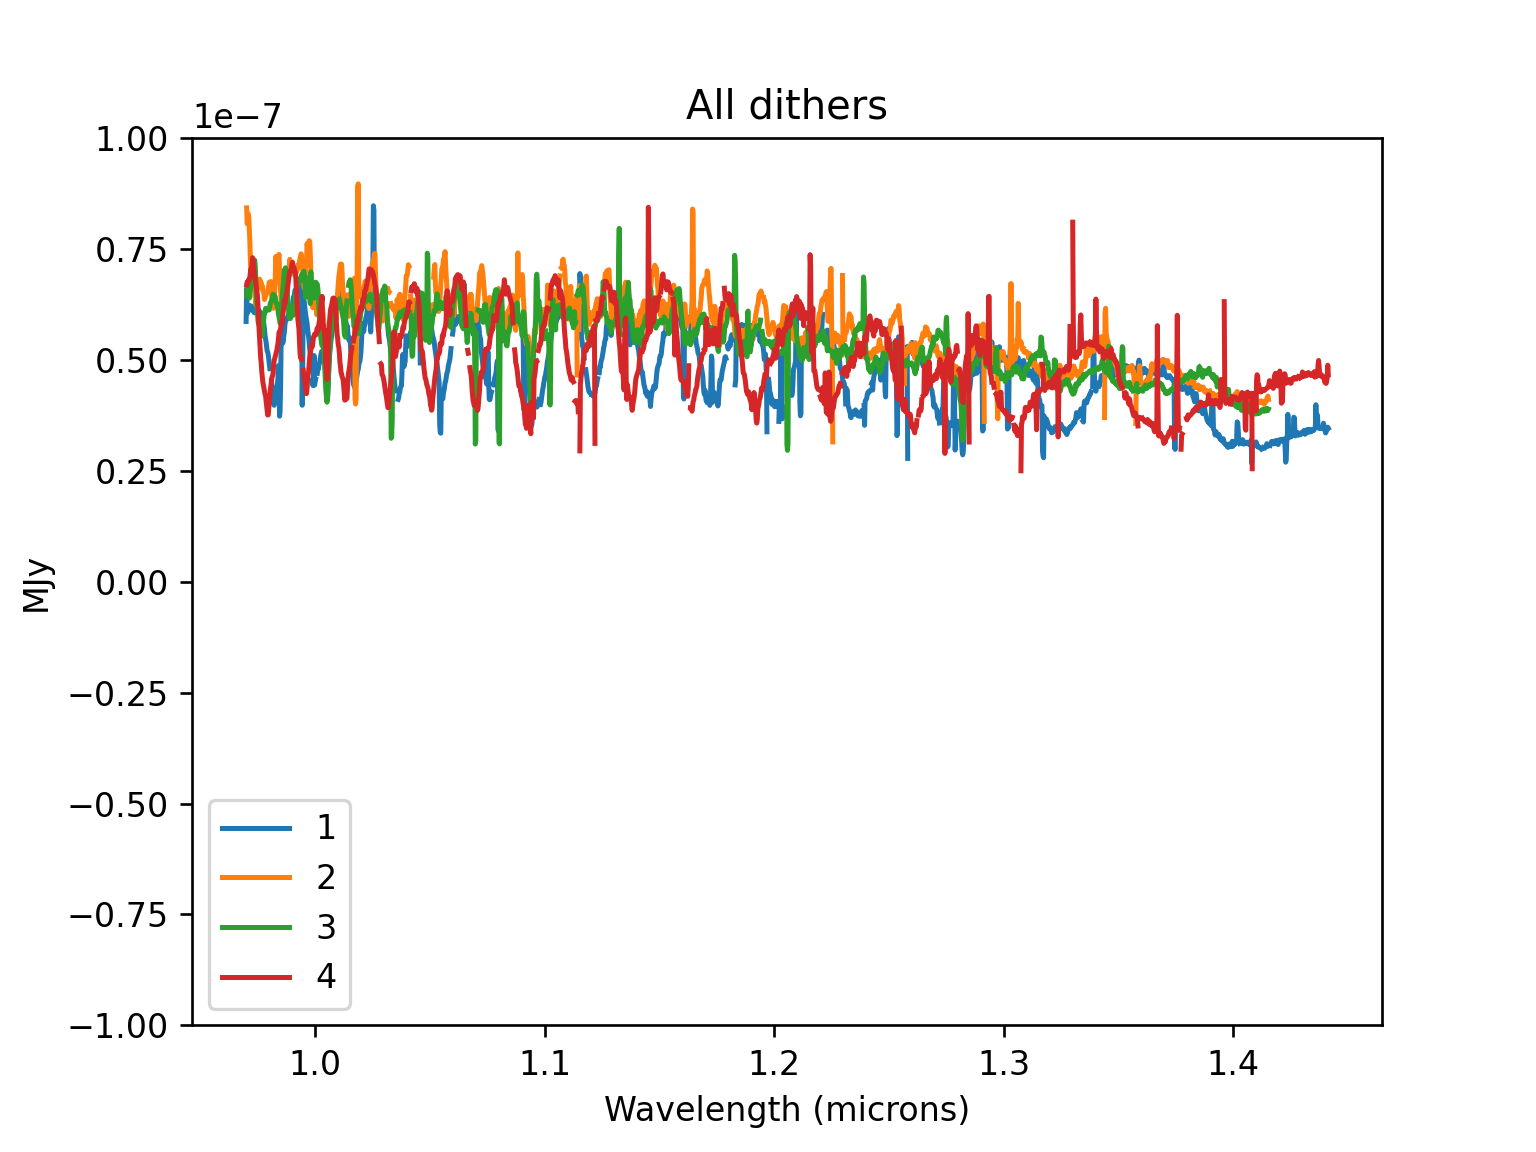

In [73]:
#clipping spectra to remove high value pixels that may or may not be from cosmic rays.

bad_edge = n.where(wavelength1 > 1.4156)
flux2[bad_edge] = n.nan
flux3[bad_edge] = n.nan

bad_edge2 = n.where(wavelength1 > 1.4417)
flux1[bad_edge2] = n.nan
flux4[bad_edge2] = n.nan

bad_edge3 = n.where(wavelength1 < .96726)
flux1[bad_edge3] = n.nan
flux2[bad_edge3] = n.nan
flux3[bad_edge3] = n.nan
flux4[bad_edge3] = n.nan

cutoff_high = 9e-8
cutoff_low = 2.5e-8
cosmic_ray1 = n.where( (flux1 > cutoff_high) | (flux1 < cutoff_low ) )
cosmic_ray2 = n.where( (flux2 > cutoff_high) | (flux2 < cutoff_low ) )
cosmic_ray3 = n.where( (flux3 > cutoff_high) | (flux3 < cutoff_low ) )
cosmic_ray4 = n.where( (flux4 > cutoff_high) | (flux4 < cutoff_low ) )

flux1[cosmic_ray1] = n.nan
flux2[cosmic_ray2] = n.nan
flux3[cosmic_ray3] = n.nan
flux4[cosmic_ray4] = n.nan

%matplotlib notebook
plt.title('All dithers')
plt.plot(wavelength1, flux1, label = '1')
plt.plot(wavelength2, flux2, label = '2')
plt.plot(wavelength3, flux3, label = '3')
plt.plot(wavelength4, flux4, label = '4')
plt.ylim([-10e-8,10e-8])
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')
plt.legend()

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/216781647.py:11: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(errors[:,i])**2


<IPython.core.display.Javascript object>


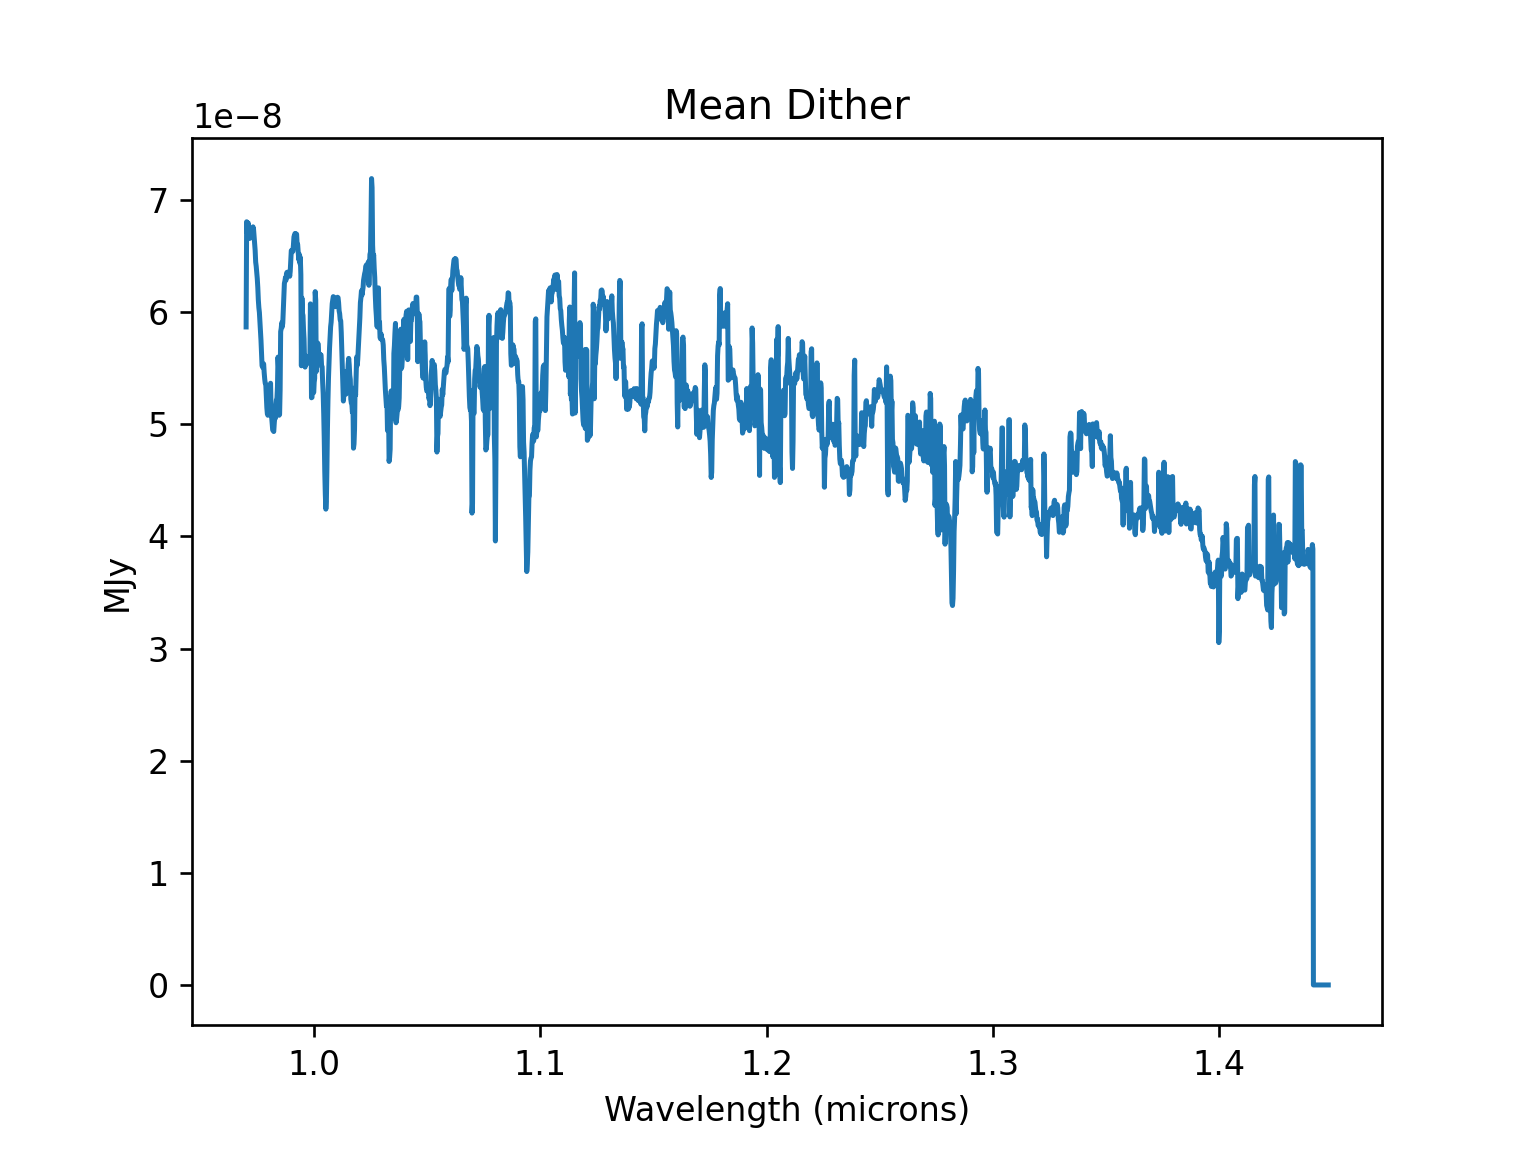

In [74]:
#taking a weighted mean of the 4 dithers to get a spectrum and error bars for an initial check.
fluxes = n.vstack([flux1, flux2, flux3, flux4])
errors = n.vstack([error1, error2, error3, error4])

flux_mean = n.zeros(len(wavelength1))


for i in n.arange(0,len(wavelength1)):
    
    flux_values = fluxes[:,i]
    weights = 1/(errors[:,i])**2
    
    good = n.where(n.isnan(flux_values) == False)
    
    flux_values = flux_values[good]
    weights = weights[good]
    
    if len(flux_values) == 0:
        flux_mean[i] = 0
        
    else:
        flux_mean[i] = n.average(flux_values, weights= weights)

%matplotlib notebook
plt.title('Mean Dither')
plt.ylabel('MJy')
plt.xlabel('Wavelength (microns)')
plt.plot(wavelength1, flux_mean)

In [75]:
#take a median but initally make a sigma clip within each wavelength element.
flux_update = n.zeros(len(flux_mean))
flux_error_update = n.zeros(len(flux_mean))
cutoff_high = 9e-8
cutoff_low = 2.5e-8

for i, wave in enumerate(wavelength1):

    flux_std = abs((fluxes[:,i] - n.nanmedian(fluxes[:,i]))/ n.nanstd(fluxes[:,i]))
    
    outlier = n.where(flux_std > 1)
    
    if len(outlier[0]) > 0:
 
    
        order = n.argsort(flux_std)
        flux_std = flux_std[order]

        flux_subset = fluxes[:,i][order]
        error_subset = errors[:,i][order]

        flux_subset_update = flux_subset[0:3]
        error_subset_update = error_subset[0:3]
        
        weights = 1/(error_subset_update)**2
        
        
        #make a n.nan clip and hard cut off 
        bad = n.where((flux_subset_update > cutoff_high) | (flux_subset_update < cutoff_low) )
        flux_subset_update[bad] = n.nan
        error_subset_update[bad] = n.nan

        good = n.where(n.isnan(flux_subset_update) == False)
        
        flux_subset_update = flux_subset_update[good]
        weights = weights[good]
        error_subset_update = error_subset_update[good]
        
        if len(good[0]) < 1:
            new_flux_mean = n.nan
            new_flux_mean_err = n.nan
            
        else:
            new_flux_mean = n.average(flux_subset_update, weights = weights) 
            new_flux_mean_err = n.sqrt(n.sum((weights * error_subset_update)**2) / (n.sum(weights)**2))
    #    
        flux_update[i] = new_flux_mean
        flux_error_update[i] = new_flux_mean_err
    else:
        
        flux_subset = fluxes[:,i]
        error_subset = errors[:,i]
        
        weights = 1/(error_subset)**2
        
        bad = n.where((flux_subset > cutoff_high) | (flux_subset < cutoff_low) )
        flux_subset[bad] = n.nan
        error_subset[bad] = n.nan
        
        good = n.where(n.isnan(flux_subset) == False)
        
        
        if len(good[0]) < 1:
            new_flux_mean = n.nan
            new_flux_mean_err = n.nan
            
        else:     
    
            flux_subset= flux_subset[good]
            weights = weights[good]
            error_subset = error_subset[good]
        
            new_flux_mean = n.average(flux_subset, weights = weights)
            new_flux_mean_err = n.sqrt(n.sum((weights * error_subset)**2) / (n.sum(weights)**2))
        
        flux_update[i] = new_flux_mean
        flux_error_update[i] = new_flux_mean_err

/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/2533806673.py:9: RuntimeWarning: invalid value encountered in divide
  flux_std = abs((fluxes[:,i] - n.nanmedian(fluxes[:,i]))/ n.nanstd(fluxes[:,i]))
/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/2533806673.py:54: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(error_subset)**2
/var/folders/1s/nd774lkj1234c0k9rq5n8gn40000gn/T/ipykernel_39191/2533806673.py:25: RuntimeWarning: divide by zero encountered in divide
  weights = 1/(error_subset_update)**2
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/zen/opt/miniconda3/envs/jwst_env_current/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=dd

<IPython.core.display.Javascript object>


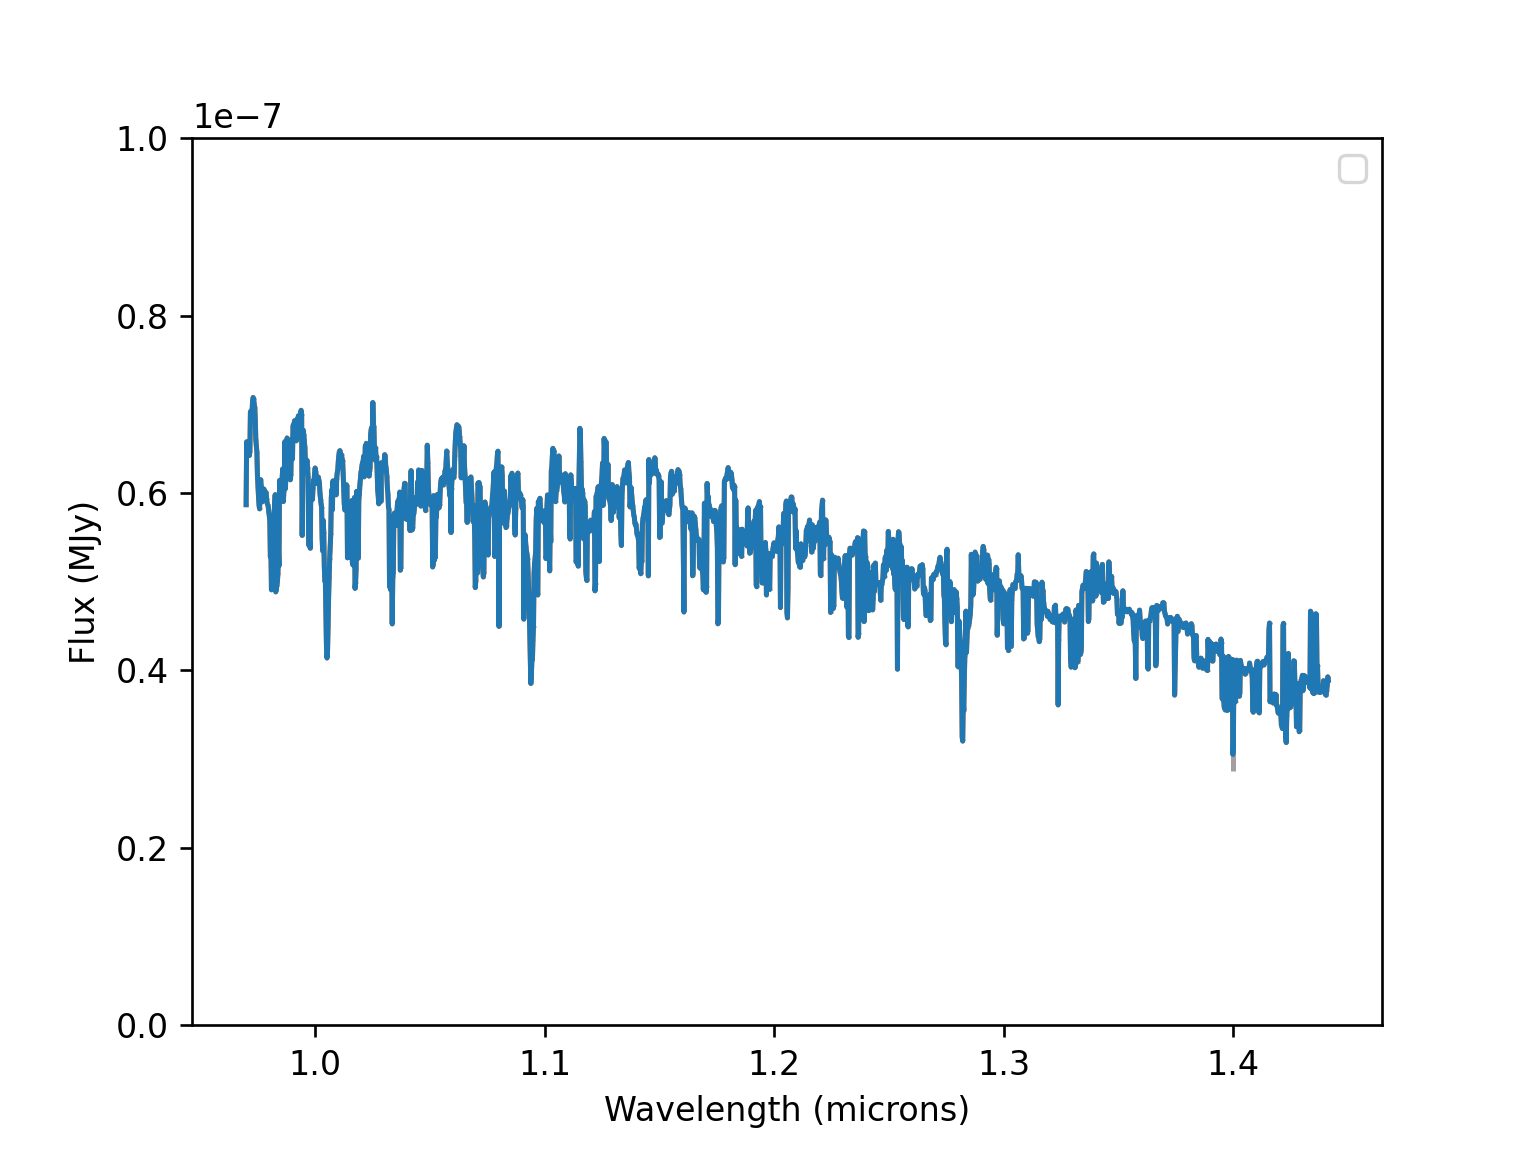

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Wavelength (microns)')

In [76]:
%matplotlib notebook
plt.errorbar(wavelength1, flux_update, yerr = flux_error_update, linestyle = None, ecolor = '#a19fa1')
plt.plot(wavelength1, flux_update)
plt.ylim([0,1e-7])
plt.legend()
plt.ylabel('Flux (MJy)')
plt.xlabel('Wavelength (microns)')

<IPython.core.display.Javascript object>


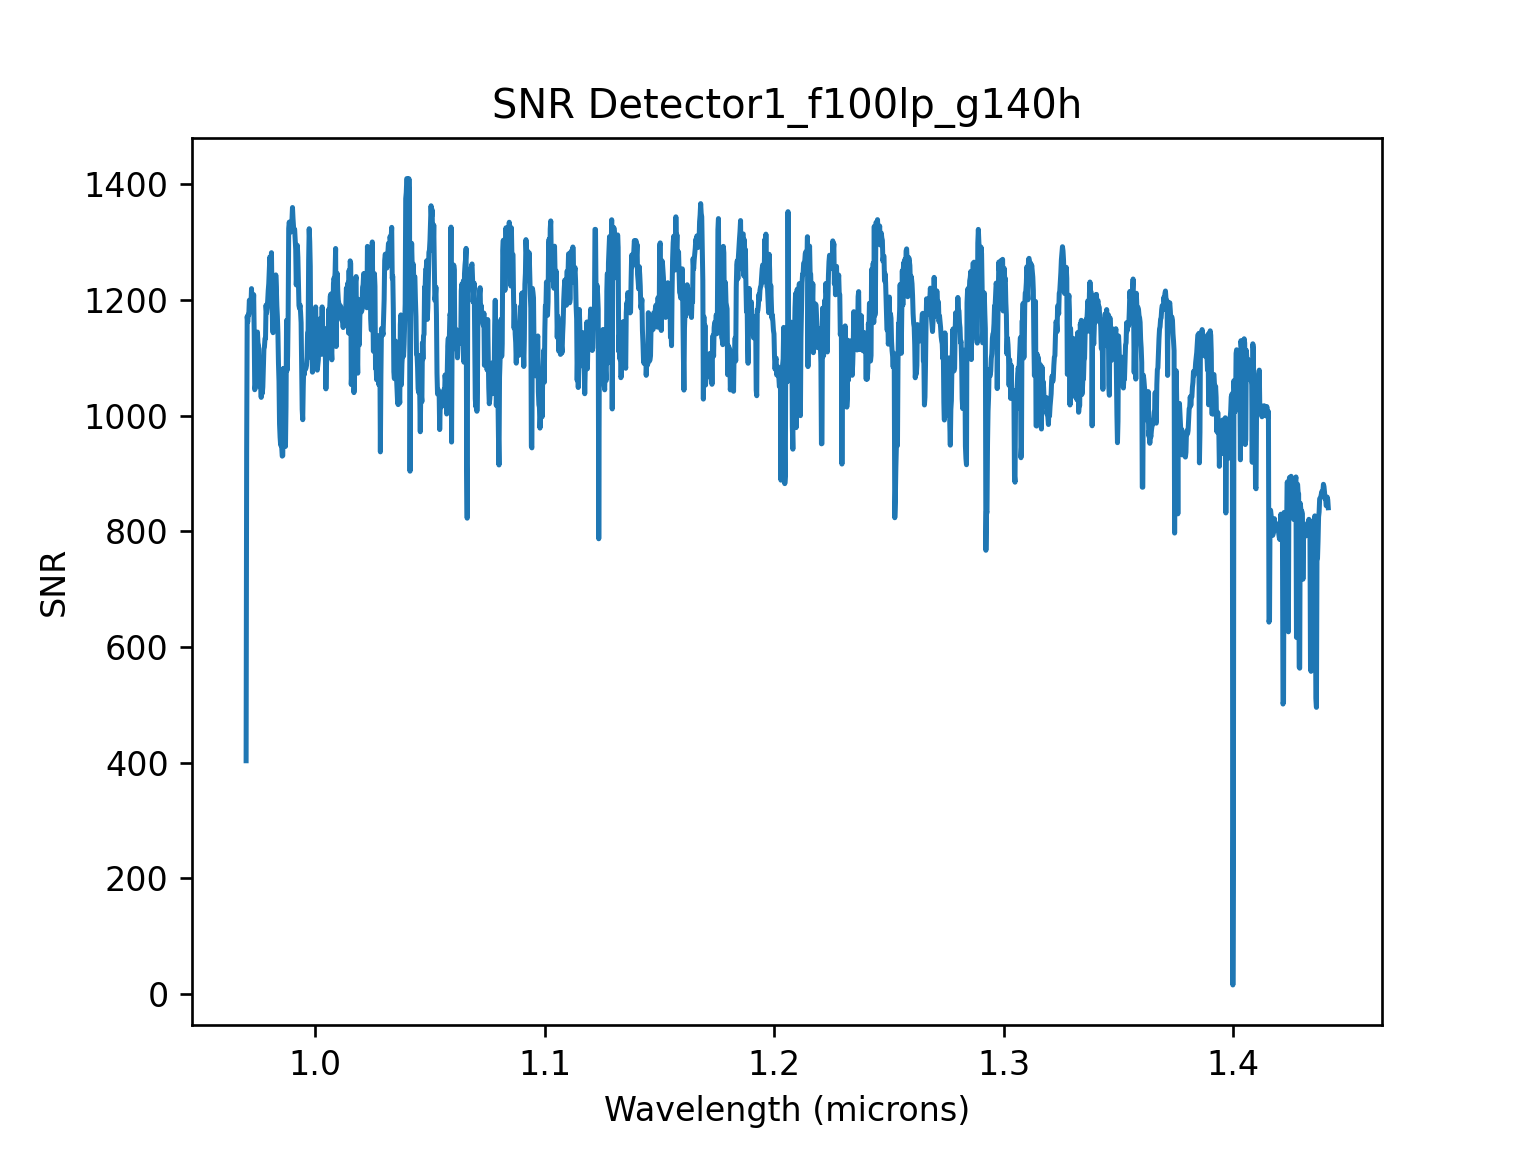

Text(0.5, 0, 'Wavelength (microns)')

In [77]:
%matplotlib notebook
plt.title('SNR Detector1_f100lp_g140h')
plt.plot(wavelength1, flux_update/flux_error_update)
plt.ylabel('SNR')
plt.xlabel('Wavelength (microns)')

In [78]:
#save text file of the spectrum
data_out = n.vstack((wavelength1,  flux_update * 1e6 , flux_error_update * 1e6))
data_out = n.transpose(data_out)

spectra_dir = 'spectra/' #if the directory does not exist create it
if not os.path.exists(spectra_dir):
    os.makedirs(spectra_dir)

header = 'wavelength (microns) flux(Jy), flux error(Jy)'
n.savetxt('spectra/detector1_f100lp_g140h.txt', data_out, header = header)